In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import evofr as ef
from evofr.plotting import *
import string


# TODO: Get proper data files
# TODO: Move data processing to another notebook
raw_seq = pd.read_csv("../../HHMI_poster/data/seq_counts_nextstrain_clades_usa.tsv.gz", sep="\t").rename(columns={"clade": "variant"})
raw_cases =  pd.read_csv("../../HHMI_poster/data/case_counts_usa.tsv.gz", sep="\t")

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils

In [3]:
date_end = "2022-09-01"
date_start = "2021-03-01"
def filter_dates(df, date_start, date_end):
    _df = df[df.date < date_end]
    _df = _df[_df.date > date_start].copy()
    return _df

raw_seq = filter_dates(raw_seq, date_start, date_end)
raw_cases = filter_dates(raw_cases, date_start, date_end) # Cases stop in 2022?

In [4]:
# Need to merge in ons data
raw_cases_ons = pd.read_csv("../../rt-from-frequency-dynamics/data/uk-ons/prepared_cases_ons.tsv", sep="\t")
raw_cases_ons["location"] = "England"
raw_seq_ons = pd.read_csv("../../rt-from-frequency-dynamics/data/uk-ons/uk-ons-variant-sequence-counts.tsv", sep="\t")

raw_seq_ons = filter_dates(raw_seq_ons, date_start, date_end)
raw_cases_ons = filter_dates(raw_cases_ons, date_start, date_end) # Cases stop in 2022?

# TODO: Merge in raw_seq_ons to raw_seq
raw_cases = pd.concat((raw_cases, raw_cases_ons))
raw_seq = pd.concat((raw_seq, raw_seq_ons))

In [5]:
from relative_fitness_hsgp import RelativeFitnessHSGP, SquaredExponential, Matern
import numpyro.distributions as dist

hsgp_mat = Matern(
    L=1000, 
    num_basis=50,
    rho = dist.HalfNormal(100),
    alpha = dist.HalfNormal(0.1),
    nu=5/2)
hsgp_sq = SquaredExponential(
    L=1000, 
    num_basis=50,
    rho = dist.HalfNormal(100),
    alpha = dist.HalfNormal(1e-1))
fitness_model = RelativeFitnessHSGP(hsgp_mat) # Do I need to add intercepts?
inference_method = ef.InferNUTS(num_samples=500, num_warmup=500)
inference_method = ef.InferMAP(iters=100_000, lr=4e-4)
#inference_method = ef.InferFullRank(num_samples=500, iters=100_000, lr=4e-4)


In [6]:
raw_seq.variant.unique()

array(['19A', '19B', '20A', '20B', '20C', '20D', '20G', '20H', '20I',
       '20J', '21A', '21C', '21D', '21F', '21G', '21H', '21I', '21J',
       '21K', '21L', '22A', '22B', '22C', '22D', 'recombinant', '22E',
       '21B', '20E', '21E', '21M', '22F', '23A', '23B', '23D', 'other'],
      dtype=object)

In [7]:
locations = pd.unique(raw_seq["location"])
locations = ["Nevada", "Texas", "Tennessee", "Oregon", "Pennsylvania", "Wisconsin", "Minnesota", "Massachusetts", "California", "Florida", "Michigan", "Illinois", "Ohio", "New York", "Georgia", "Virginia", "Washington"]
locations += ["England"]
data = {}
cases = {}
for loc in locations:
    data[loc] = ef.VariantFrequencies(raw_seq[raw_seq.location == loc].copy(), pivot="21K")
    cases[loc] = raw_cases[raw_cases.location == loc].copy()
data

{'Nevada': <evofr.data.variant_frequencies.VariantFrequencies at 0x29fee4e10>,
 'Texas': <evofr.data.variant_frequencies.VariantFrequencies at 0x29fef8b90>,
 'Tennessee': <evofr.data.variant_frequencies.VariantFrequencies at 0x29fef9490>,
 'Oregon': <evofr.data.variant_frequencies.VariantFrequencies at 0x29fefaf90>,
 'Pennsylvania': <evofr.data.variant_frequencies.VariantFrequencies at 0x29fefb3d0>,
 'Wisconsin': <evofr.data.variant_frequencies.VariantFrequencies at 0x29fefb950>,
 'Minnesota': <evofr.data.variant_frequencies.VariantFrequencies at 0x29ff6ff50>,
 'Massachusetts': <evofr.data.variant_frequencies.VariantFrequencies at 0x29ff6f810>,
 'California': <evofr.data.variant_frequencies.VariantFrequencies at 0x29ff9e710>,
 'Florida': <evofr.data.variant_frequencies.VariantFrequencies at 0x29ff9cd10>,
 'Michigan': <evofr.data.variant_frequencies.VariantFrequencies at 0x29ff9fad0>,
 'Illinois': <evofr.data.variant_frequencies.VariantFrequencies at 0x29ffca950>,
 'Ohio': <evofr.data.v

In [8]:
# Fit models
posteriors = {}
num_locations = len(locations)
for i, loc in enumerate(locations): # Could use tqdm
    print(f"Fitting to {loc} ({i}/{num_locations})")
    posteriors[loc] = inference_method.fit(fitness_model, data=data[loc]) 
posteriors

Fitting to Nevada
Fitting to Texas
Fitting to Tennessee
Fitting to Oregon
Fitting to Pennsylvania
Fitting to Wisconsin
Fitting to Minnesota
Fitting to Massachusetts
Fitting to California
Fitting to Florida
Fitting to Michigan
Fitting to Illinois
Fitting to Ohio
Fitting to New York
Fitting to Georgia
Fitting to Virginia
Fitting to Washington
Fitting to England


{'Nevada': <evofr.posterior.posterior_handler.PosteriorHandler at 0x2a236b890>,
 'Texas': <evofr.posterior.posterior_handler.PosteriorHandler at 0x15510de10>,
 'Tennessee': <evofr.posterior.posterior_handler.PosteriorHandler at 0x10470add0>,
 'Oregon': <evofr.posterior.posterior_handler.PosteriorHandler at 0x2a1bc1290>,
 'Pennsylvania': <evofr.posterior.posterior_handler.PosteriorHandler at 0x2a2a46a10>,
 'Wisconsin': <evofr.posterior.posterior_handler.PosteriorHandler at 0x2a431ff90>,
 'Minnesota': <evofr.posterior.posterior_handler.PosteriorHandler at 0x2a1b43890>,
 'Massachusetts': <evofr.posterior.posterior_handler.PosteriorHandler at 0x2a238b890>,
 'California': <evofr.posterior.posterior_handler.PosteriorHandler at 0x2a4acbf90>,
 'Florida': <evofr.posterior.posterior_handler.PosteriorHandler at 0x2a4a26f50>,
 'Michigan': <evofr.posterior.posterior_handler.PosteriorHandler at 0x2a7993890>,
 'Illinois': <evofr.posterior.posterior_handler.PosteriorHandler at 0x2a34dcc10>,
 'Ohio': <

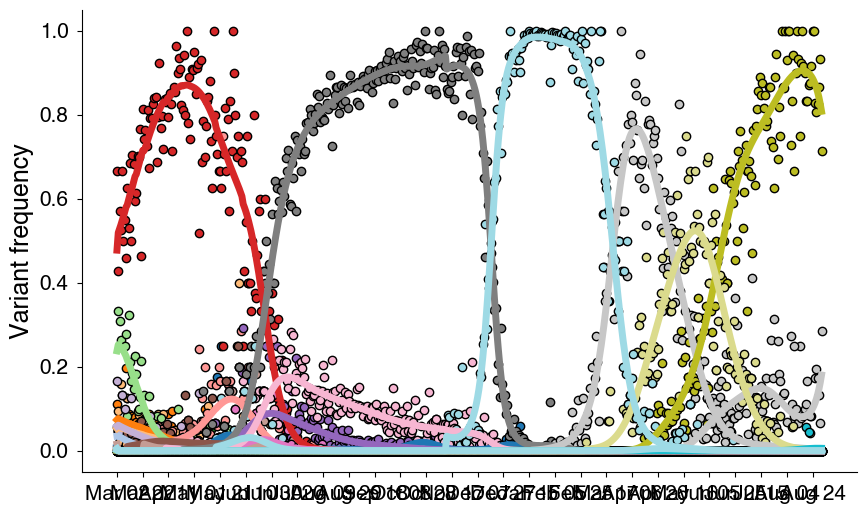

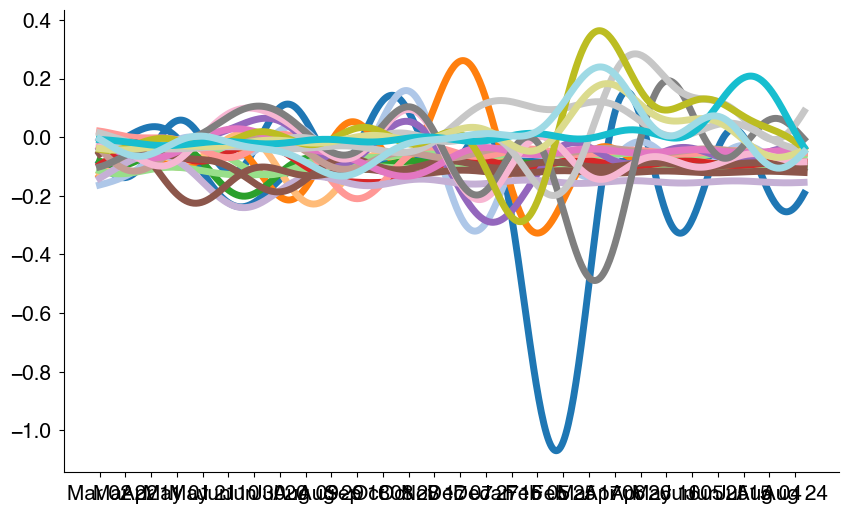

In [9]:
from evofr.plotting import FrequencyPlot, TimeVaryingPlot
FrequencyPlot(posteriors["Tennessee"]).plot()
TimeVaryingPlot(posterior=posteriors["Tennessee"], site="delta").plot()

In [10]:
def compute_selective_pressure(posterior):
    
    delta = posterior.samples["delta"]
    num_samples, T, _ = delta.shape
    delta = jnp.concatenate((delta, jnp.zeros((num_samples,T,1))), axis=-1)
    freq = posterior.samples["freq"]        
        
    # Mean fitness
    delta_bar = (delta * freq).mean(axis=-1)
    
    # Mean square deviation
    delta_sse = jnp.square(delta - delta_bar[..., None])
    selective_pressure_var = (delta_sse * freq).sum(axis=-1)
    
    # Change in relative fitness overall
    selective_pressure_expect = (jnp.diff(delta, axis=-2, prepend=jnp.nan) * freq).sum(axis=-1)
    selective_pressure = selective_pressure_var + selective_pressure_expect
    
    return delta_bar.T, selective_pressure.T

In [11]:
delta_bar, selective_pressure = compute_selective_pressure(posteriors["Washington"])

{'Nevada': <Figure size 1200x600 with 2 Axes>,
 'Texas': <Figure size 1200x600 with 2 Axes>,
 'Tennessee': <Figure size 1200x600 with 2 Axes>,
 'Oregon': <Figure size 1200x600 with 2 Axes>,
 'Pennsylvania': <Figure size 1200x600 with 2 Axes>,
 'Wisconsin': <Figure size 1200x600 with 2 Axes>,
 'Minnesota': <Figure size 1200x600 with 2 Axes>,
 'Massachusetts': <Figure size 1200x600 with 2 Axes>,
 'California': <Figure size 1200x600 with 2 Axes>,
 'Florida': <Figure size 1200x600 with 2 Axes>,
 'Michigan': <Figure size 1200x600 with 2 Axes>,
 'Illinois': <Figure size 1200x600 with 2 Axes>,
 'Ohio': <Figure size 1200x600 with 2 Axes>,
 'New York': <Figure size 1200x600 with 2 Axes>,
 'Georgia': <Figure size 1200x600 with 2 Axes>,
 'Virginia': <Figure size 1200x600 with 2 Axes>,
 'Washington': <Figure size 1200x600 with 2 Axes>,
 'England': <Figure size 1200x600 with 2 Axes>}

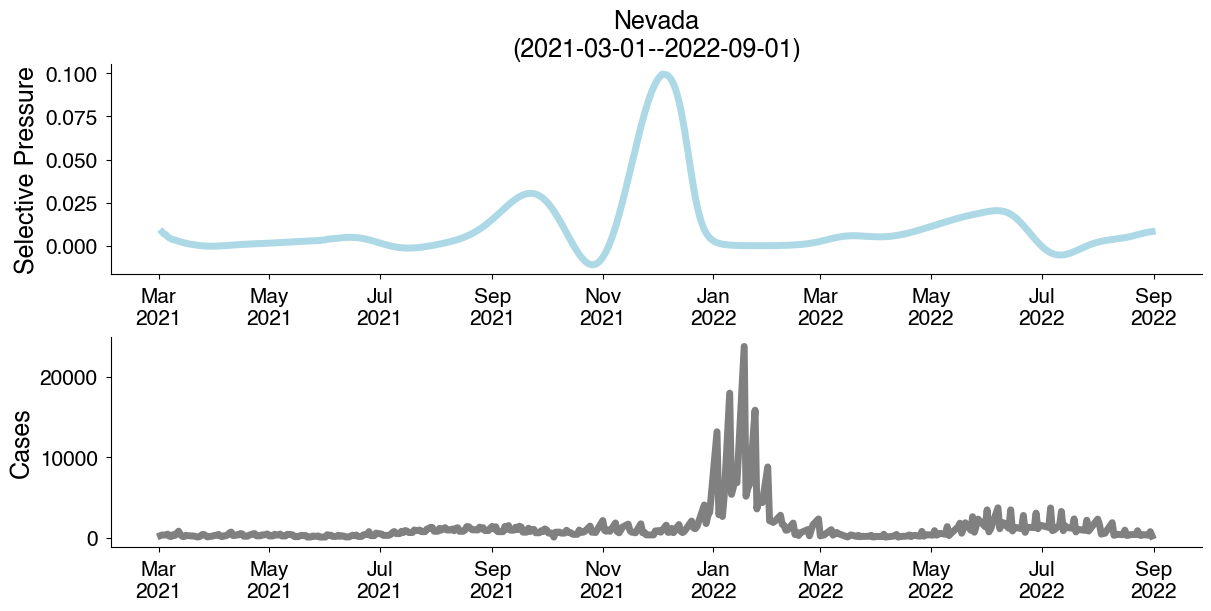

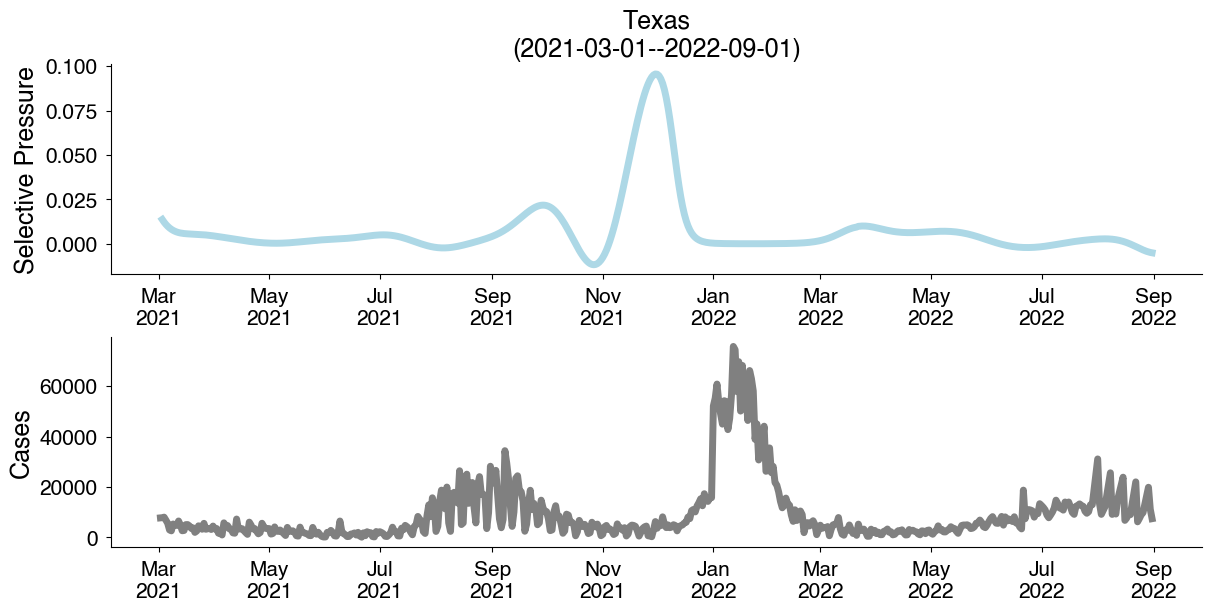

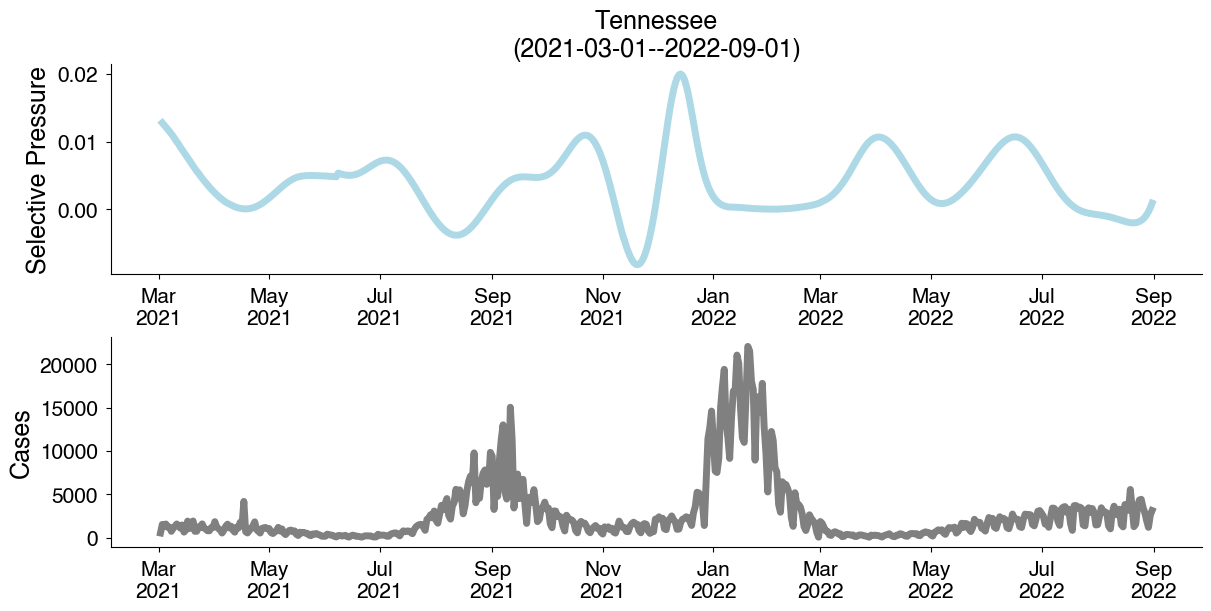

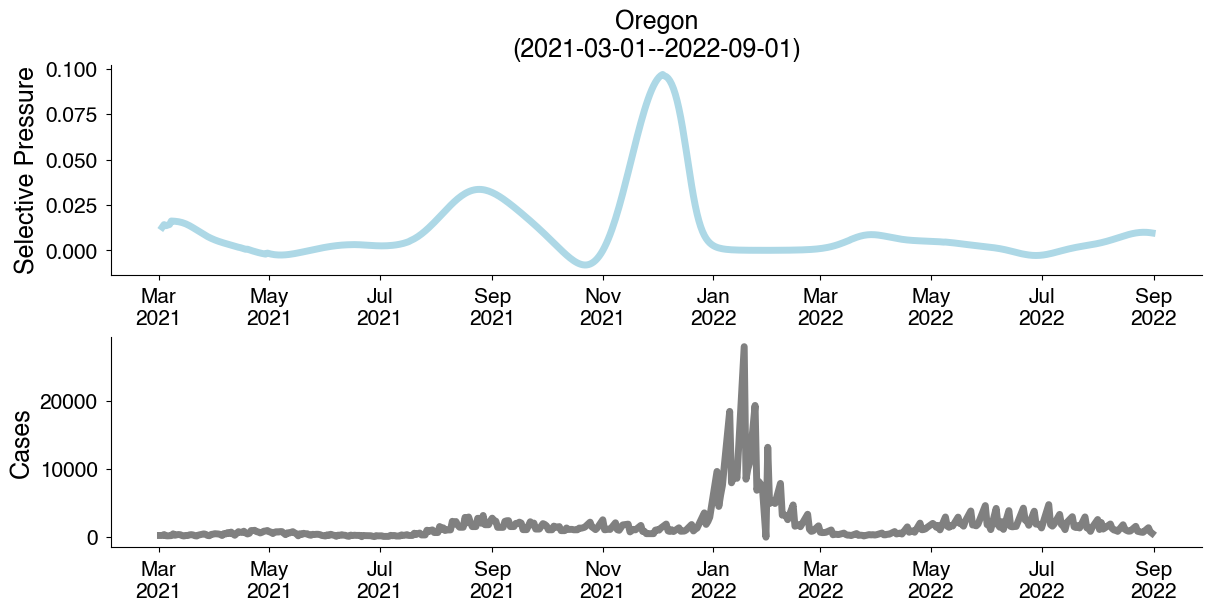

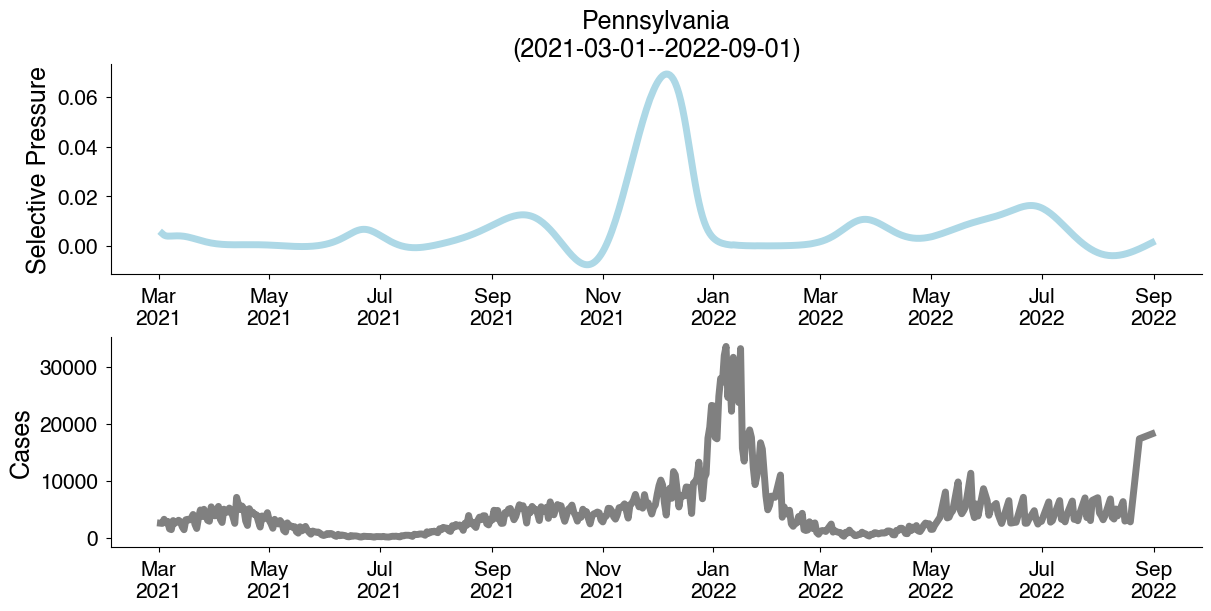

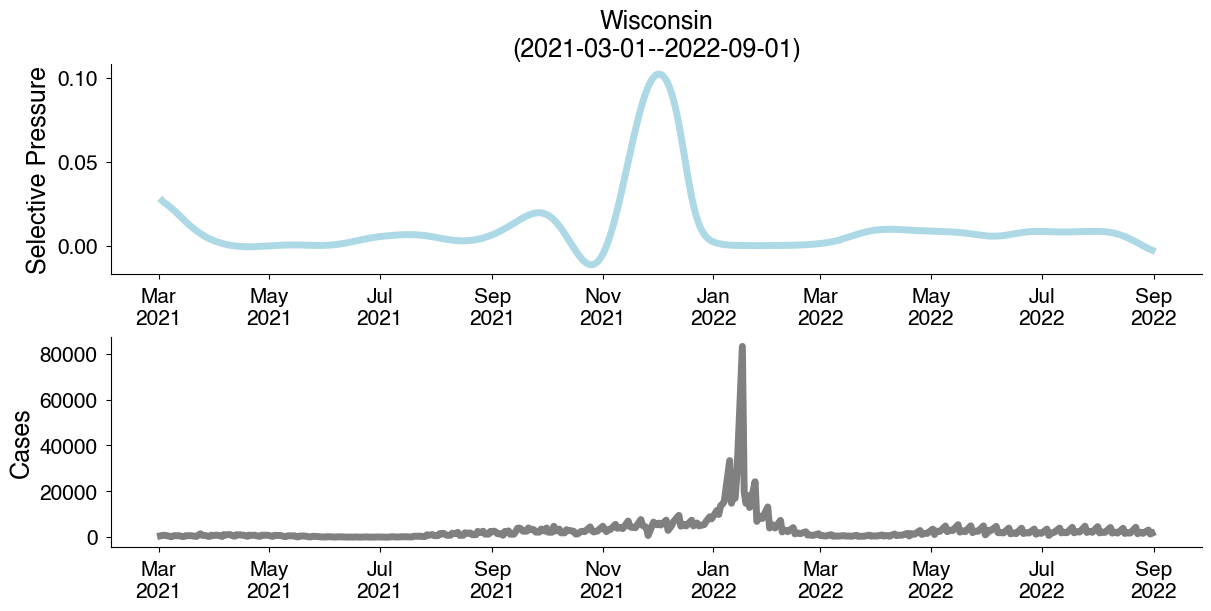

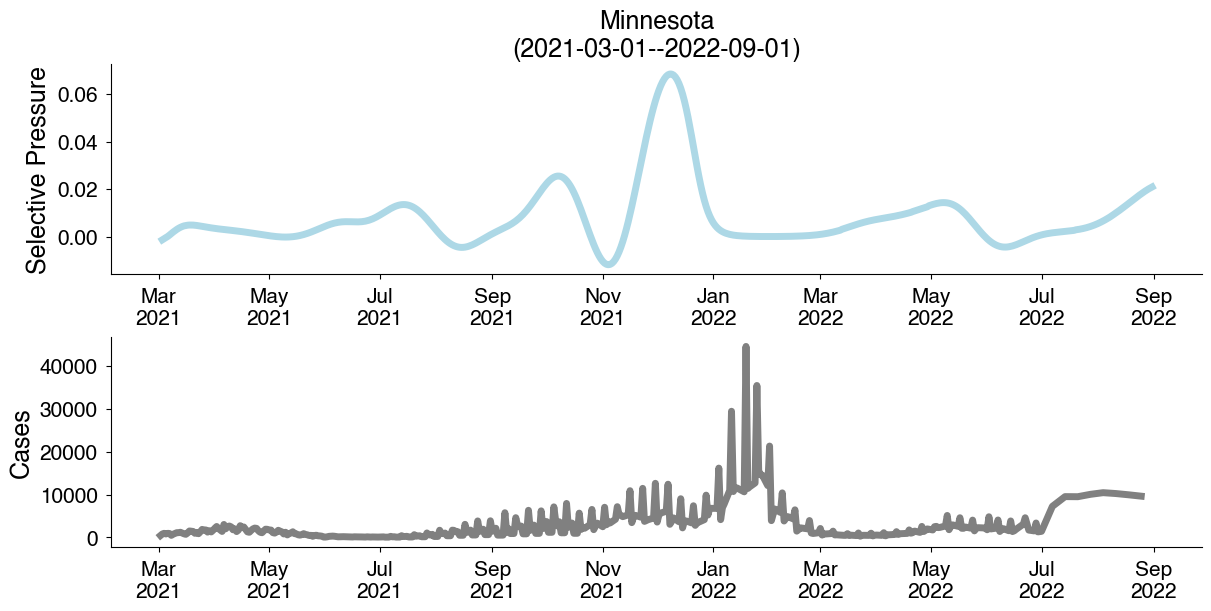

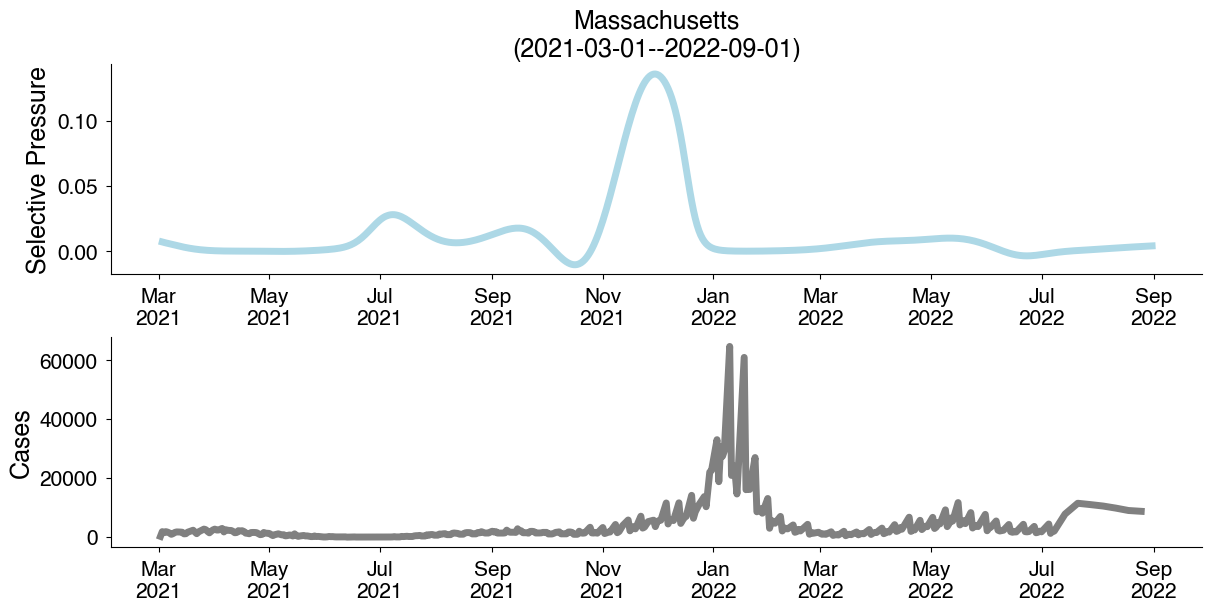

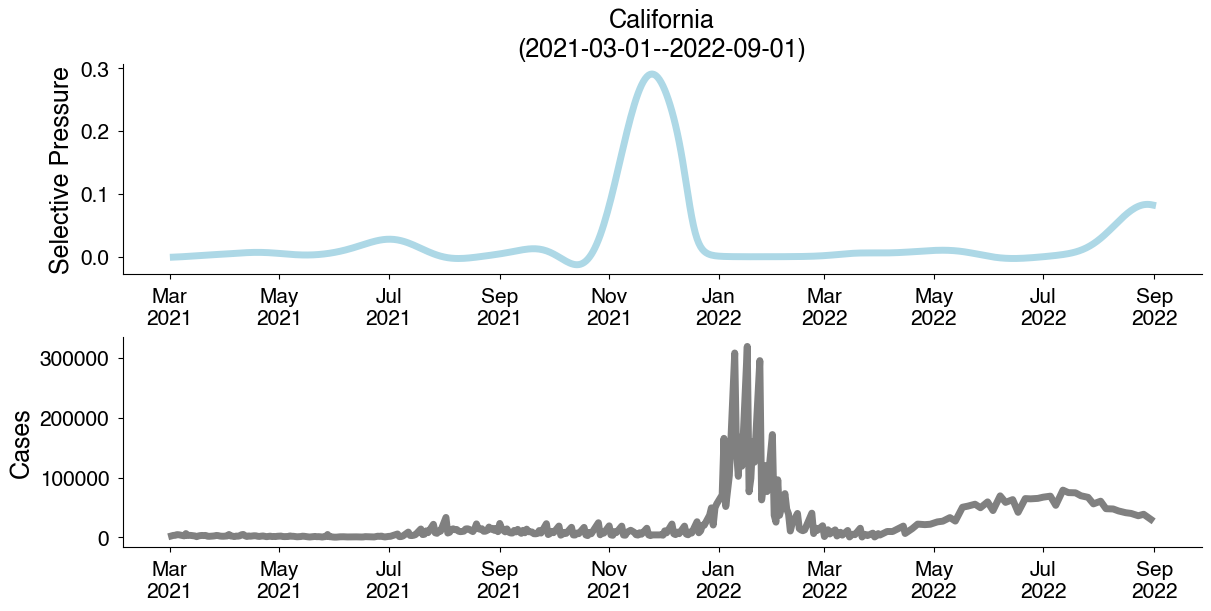

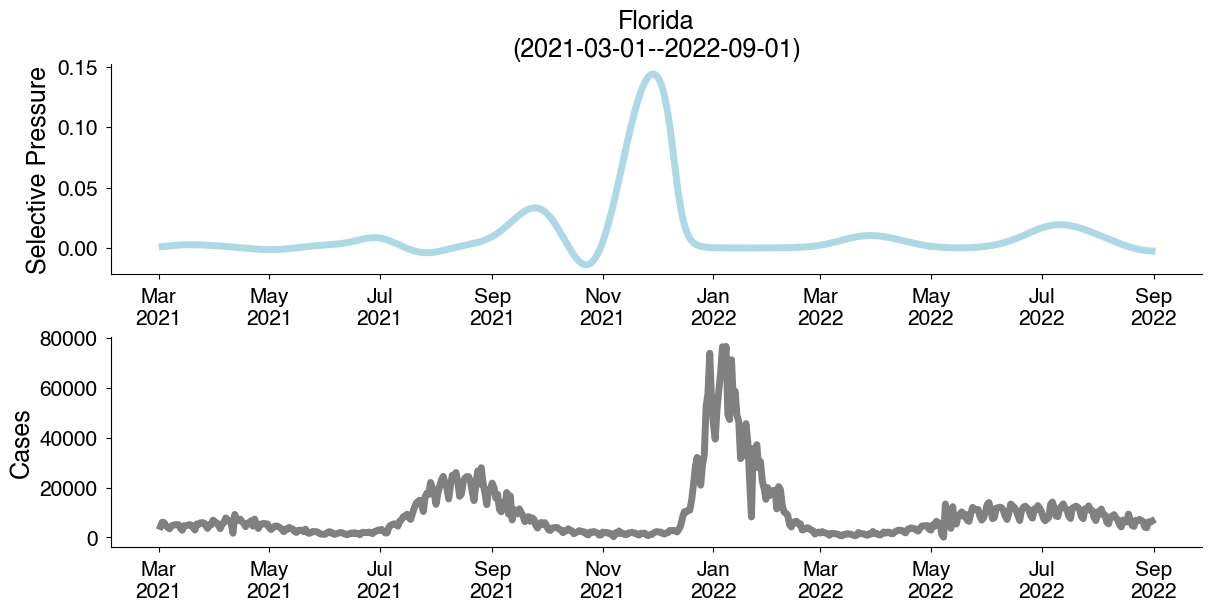

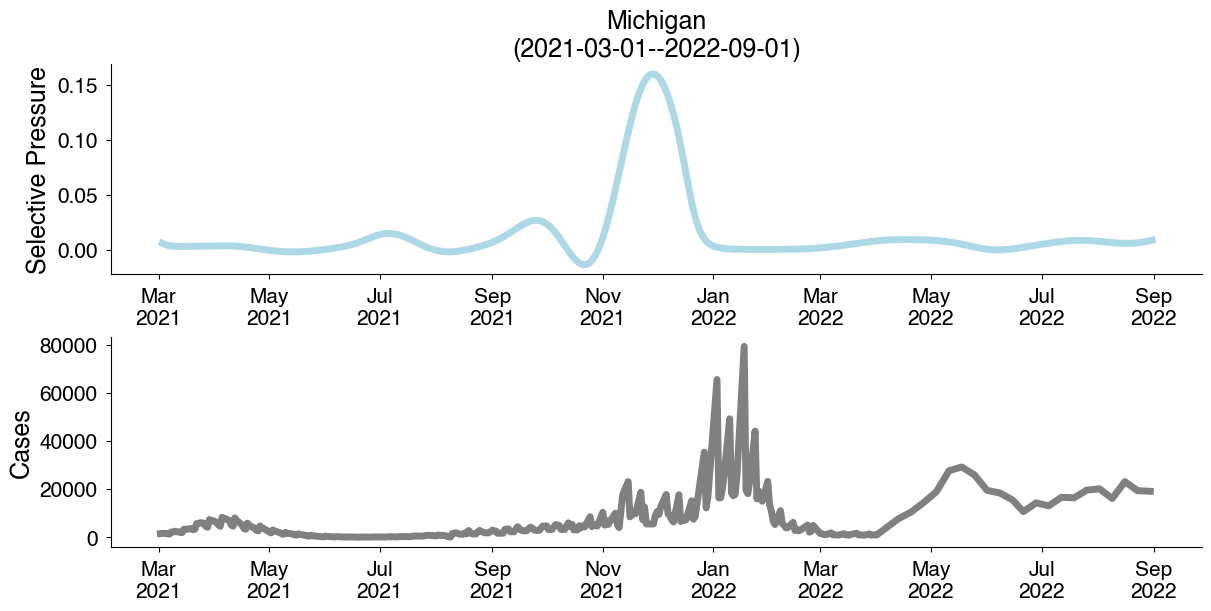

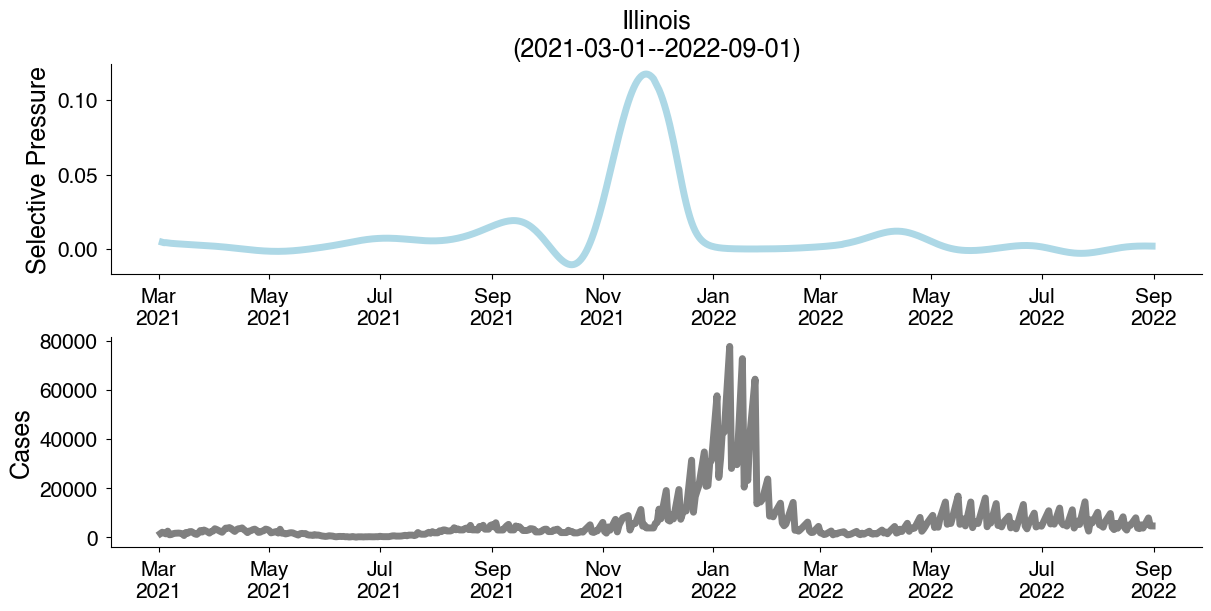

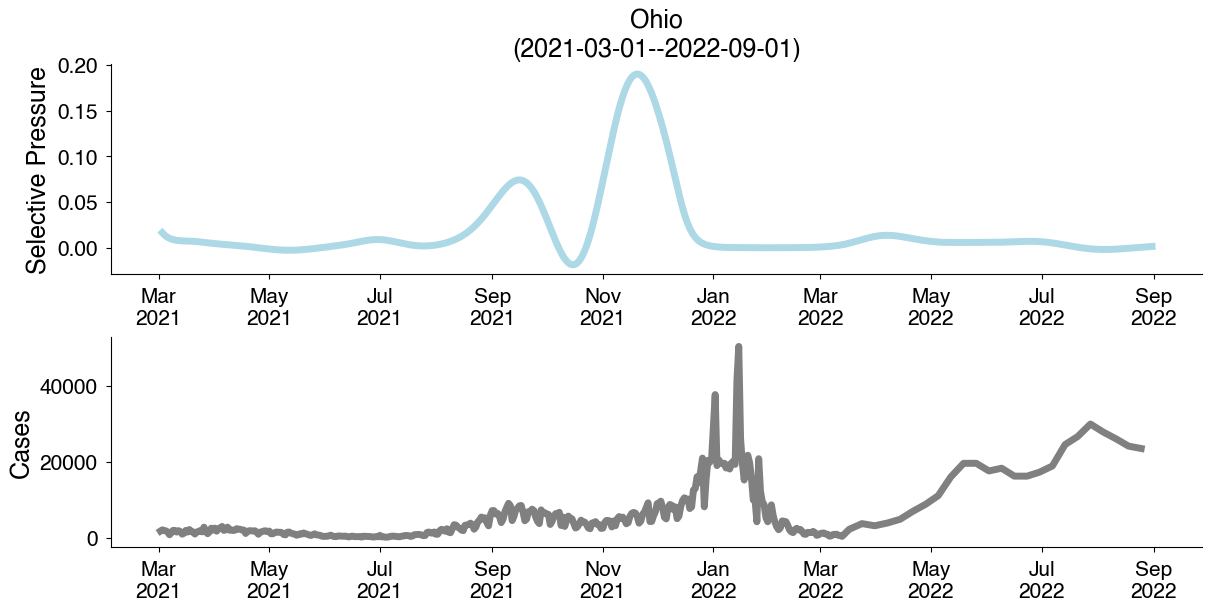

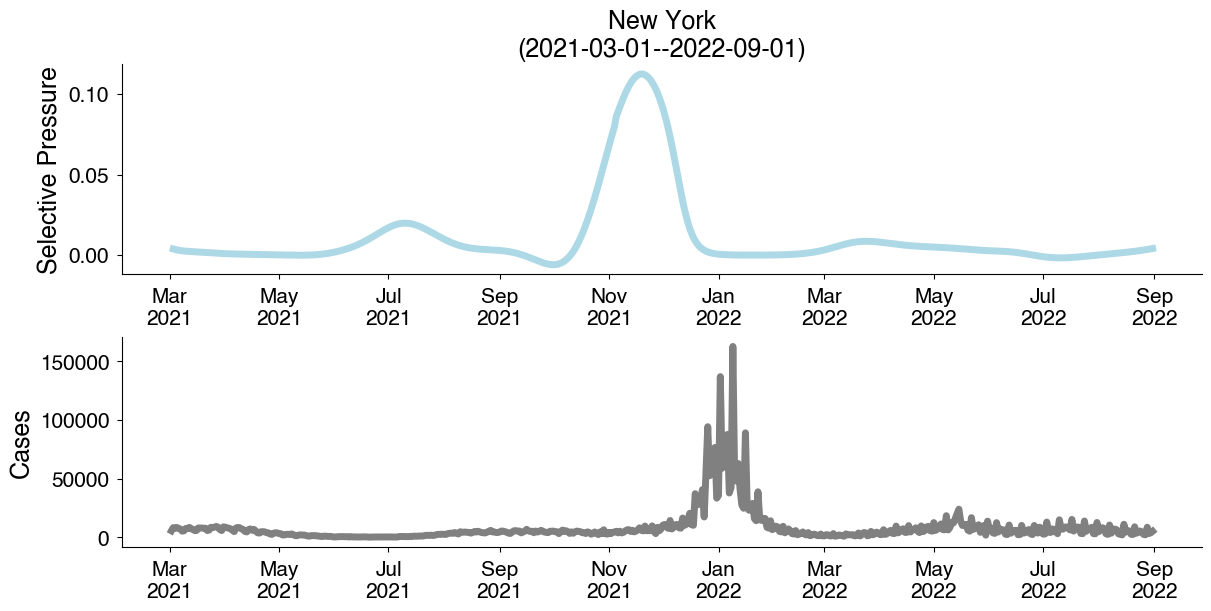

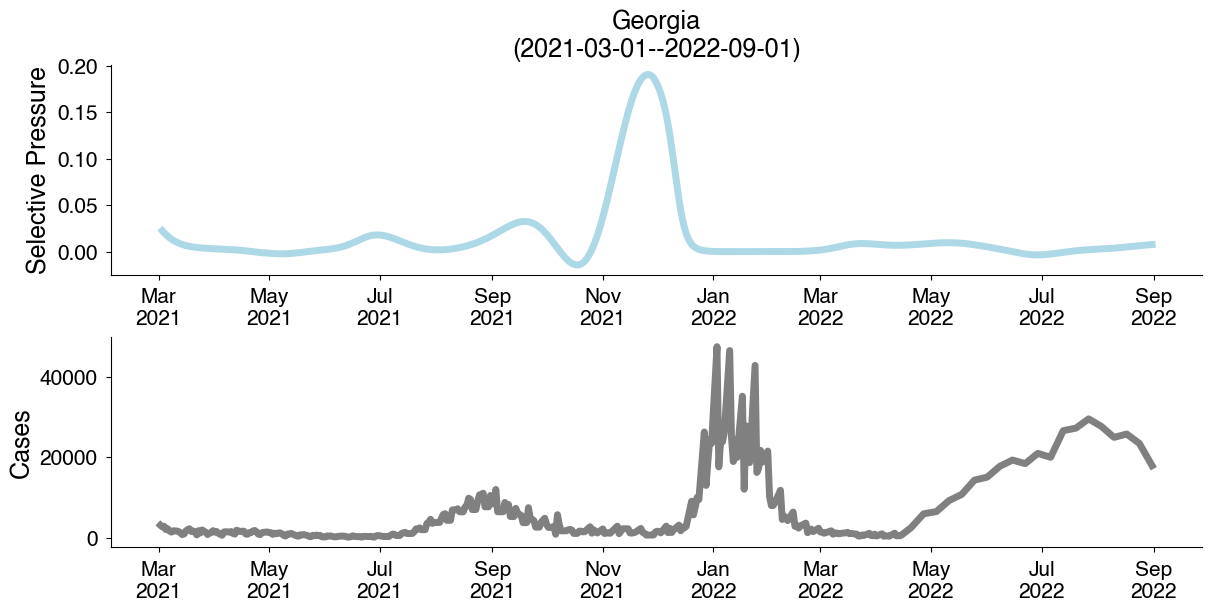

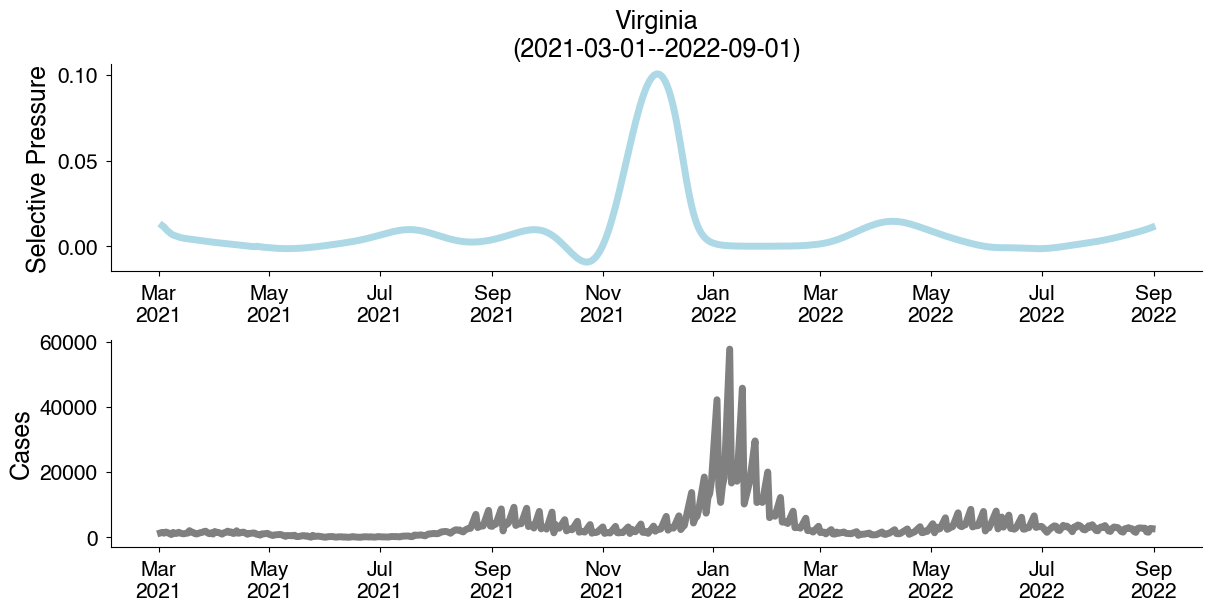

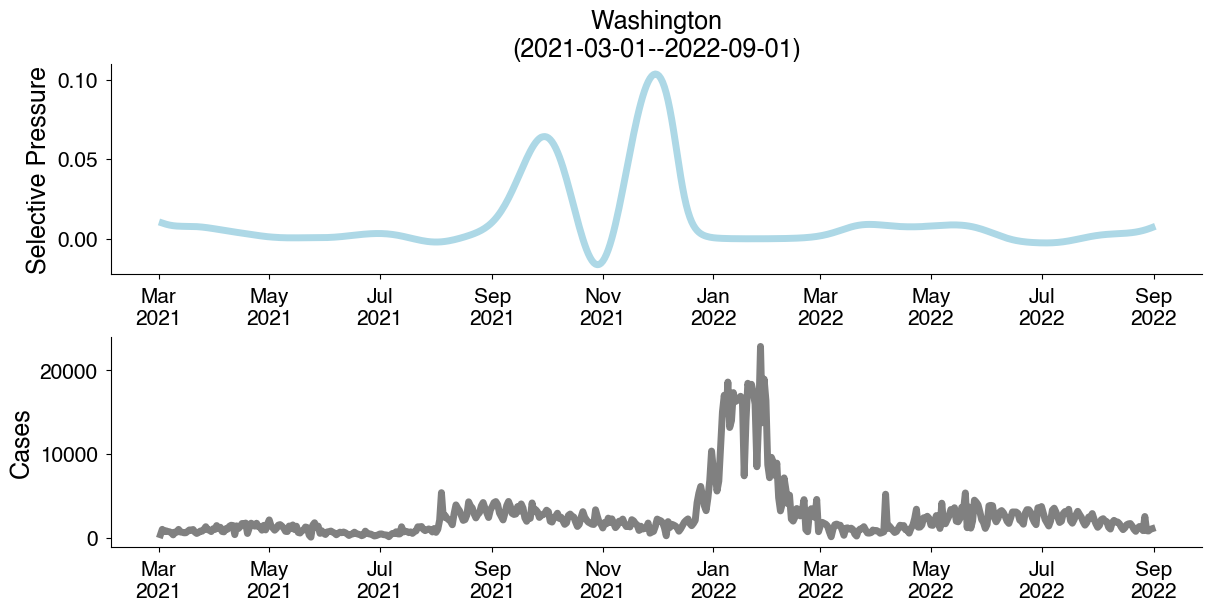

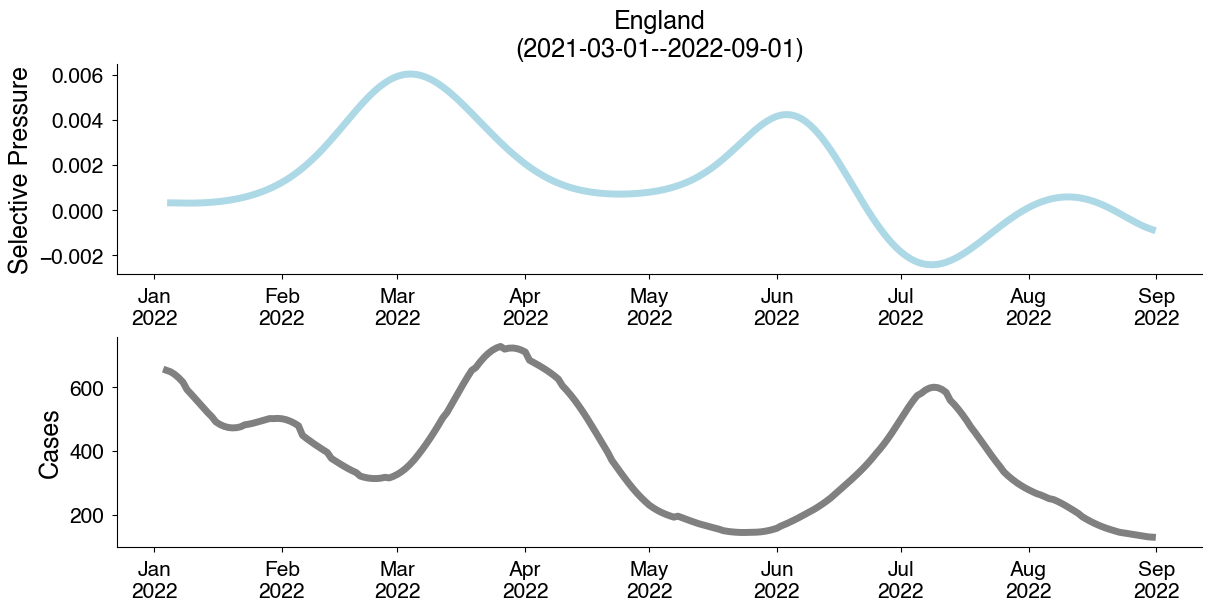

In [12]:
import matplotlib.dates as mdates

def plot_selective_pressure_cases(loc):
    # Compute selective pressure
    delta_bar, selective_pressure = compute_selective_pressure(posteriors[loc])
    
    fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=2)

    # Plot selective pressure
    ax0 = fig.add_subplot(spec[0, 0])
    t = np.arange(len(selective_pressure))
    ax0.plot(data[loc].dates, selective_pressure, color="lightblue")
    ax0.set_ylabel("Selective Pressure")
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax0.set_title(loc + f"\n({date_start}--{date_end})")

    # Plot cases
    ax1 = fig.add_subplot(spec[1, 0], sharex = ax0)
    t_cases = [t for i, t in enumerate(data[loc].dates) if t in pd.to_datetime(cases[loc].date.values)]
    ax1.plot(t_cases, cases[loc].cases, color="gray")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax1.set_ylabel("Cases")
    return fig

fig_selective_pressure_cases = {}
for loc in locations:
    fig_selective_pressure_cases[loc] = plot_selective_pressure_cases(loc)
    fig_selective_pressure_cases[loc].savefig(f"figures/selective_pressure_cases_{loc}.png")
fig_selective_pressure_cases

# Michigan data looks maybe inconsistent wtih state dashboard 

{'Nevada': <Figure size 1200x600 with 2 Axes>,
 'Texas': <Figure size 1200x600 with 2 Axes>,
 'Tennessee': <Figure size 1200x600 with 2 Axes>,
 'Oregon': <Figure size 1200x600 with 2 Axes>,
 'Pennsylvania': <Figure size 1200x600 with 2 Axes>,
 'Wisconsin': <Figure size 1200x600 with 2 Axes>,
 'Minnesota': <Figure size 1200x600 with 2 Axes>,
 'Massachusetts': <Figure size 1200x600 with 2 Axes>,
 'California': <Figure size 1200x600 with 2 Axes>,
 'Florida': <Figure size 1200x600 with 2 Axes>,
 'Michigan': <Figure size 1200x600 with 2 Axes>,
 'Illinois': <Figure size 1200x600 with 2 Axes>,
 'Ohio': <Figure size 1200x600 with 2 Axes>,
 'New York': <Figure size 1200x600 with 2 Axes>,
 'Georgia': <Figure size 1200x600 with 2 Axes>,
 'Virginia': <Figure size 1200x600 with 2 Axes>,
 'Washington': <Figure size 1200x600 with 2 Axes>,
 'England': <Figure size 1200x600 with 2 Axes>}

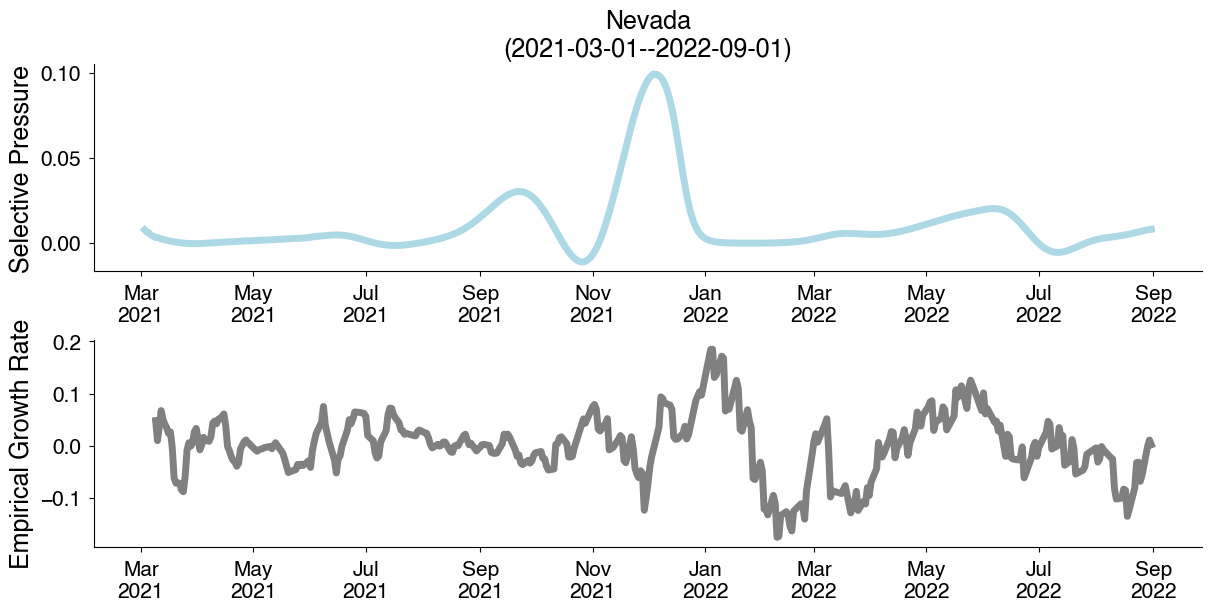

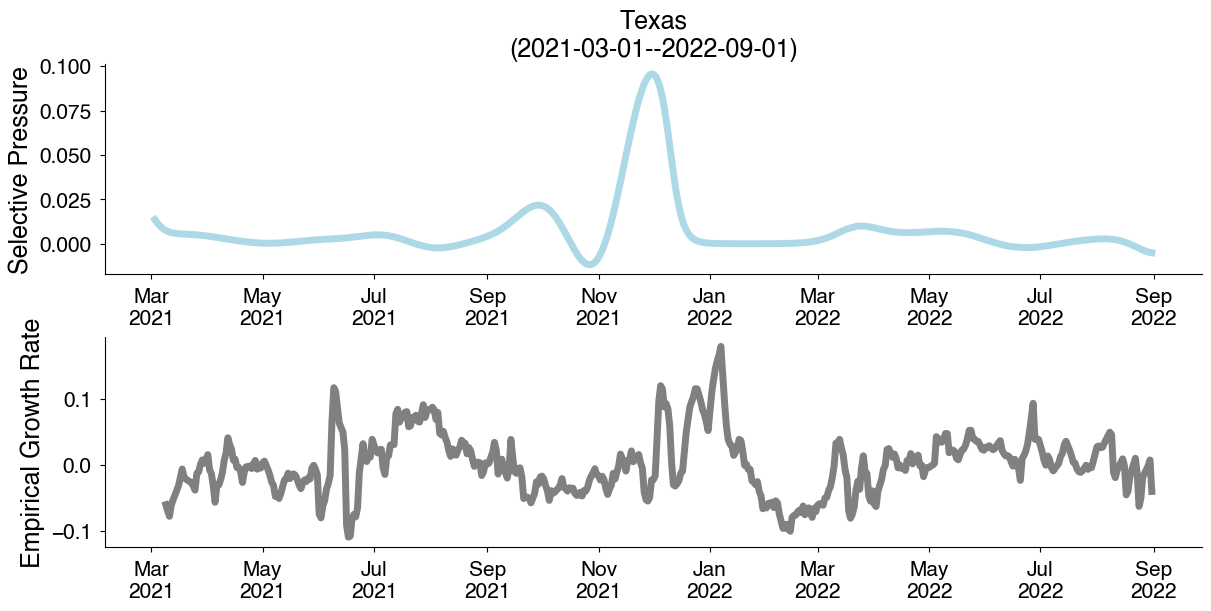

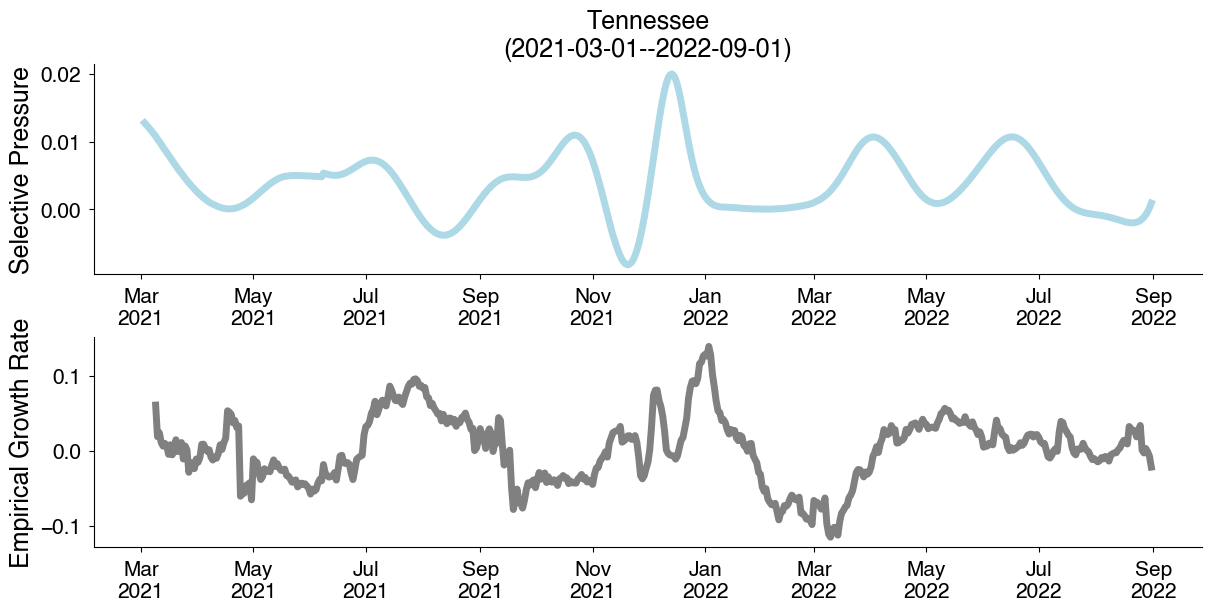

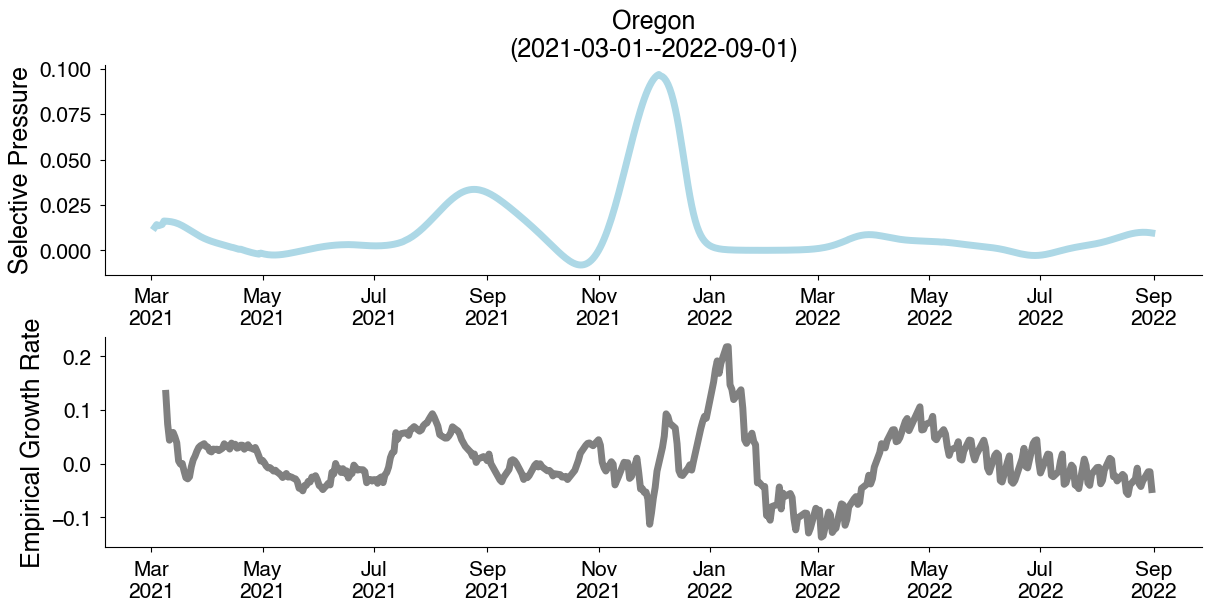

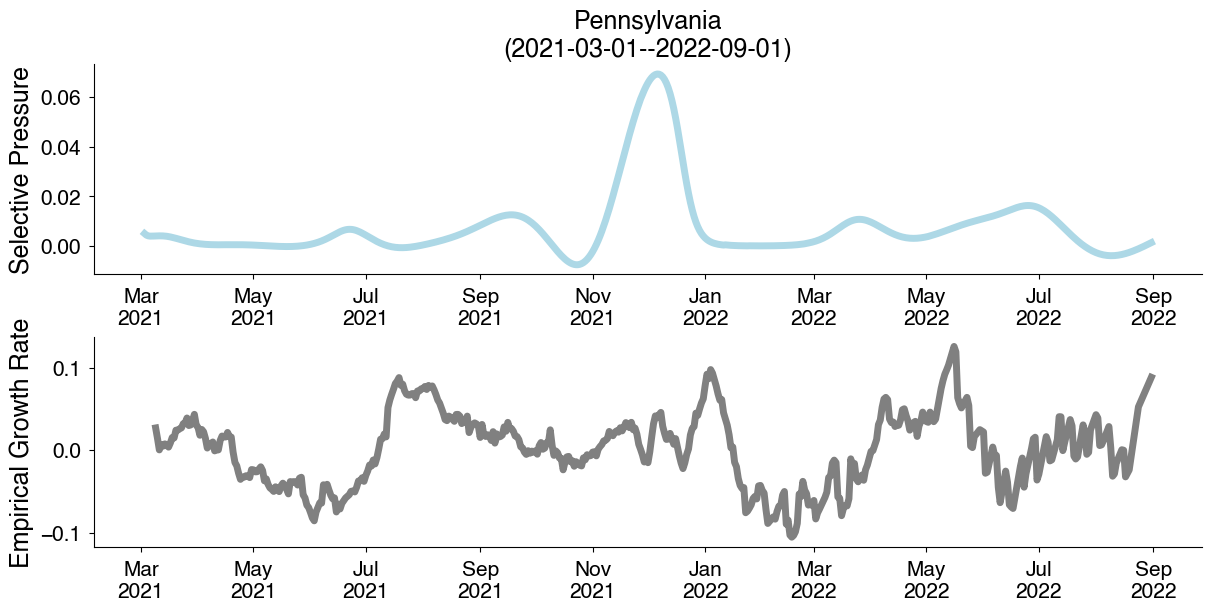

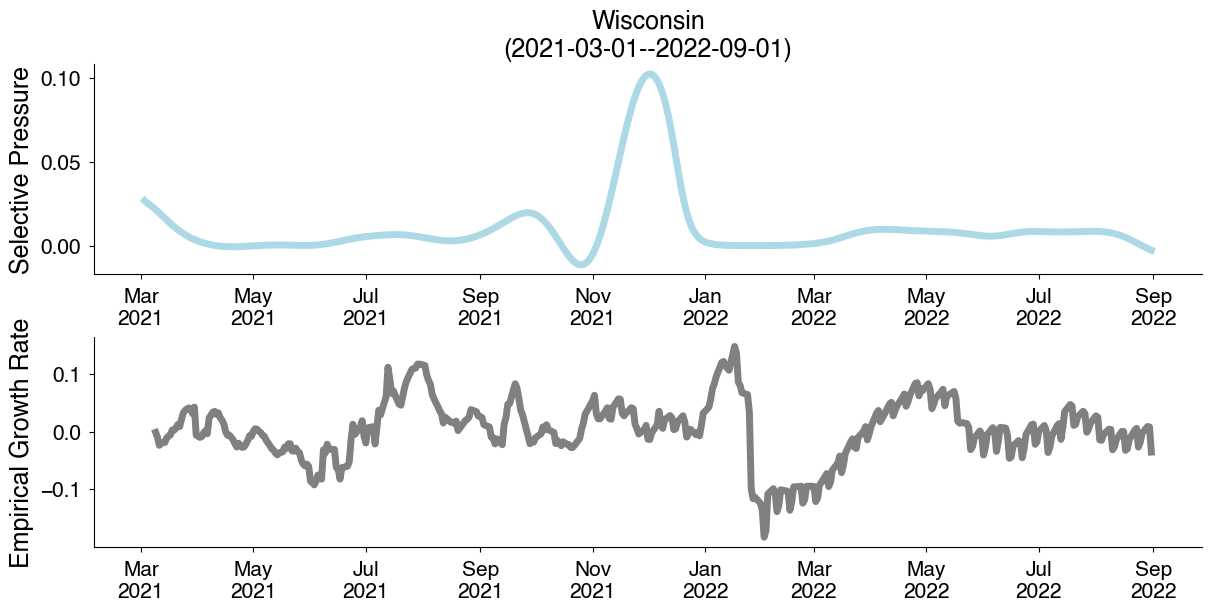

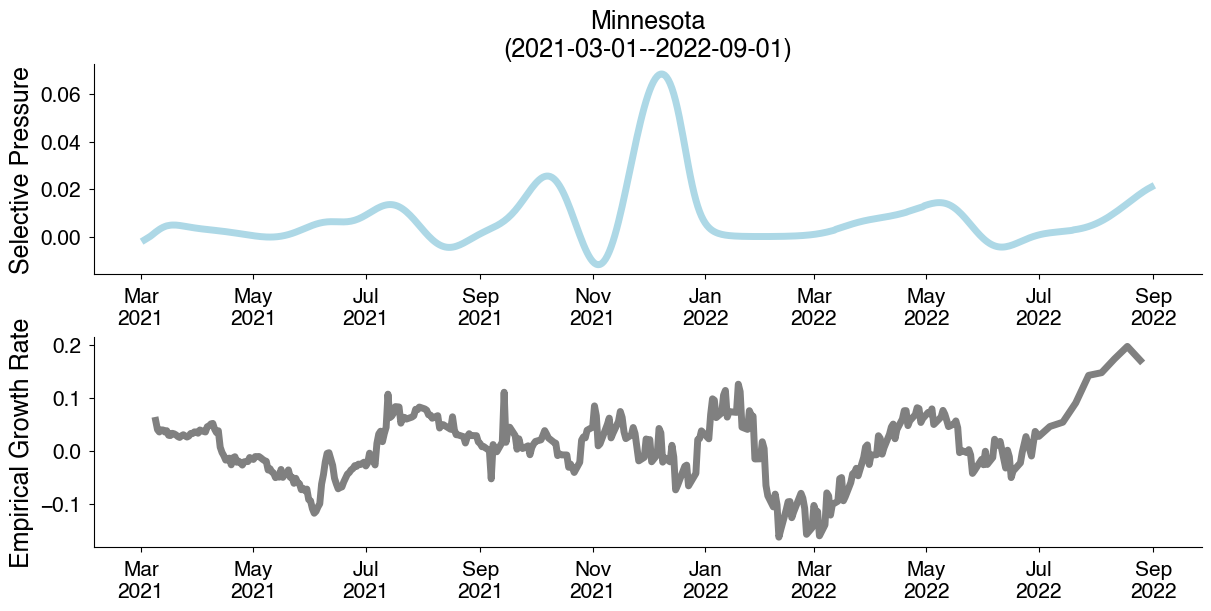

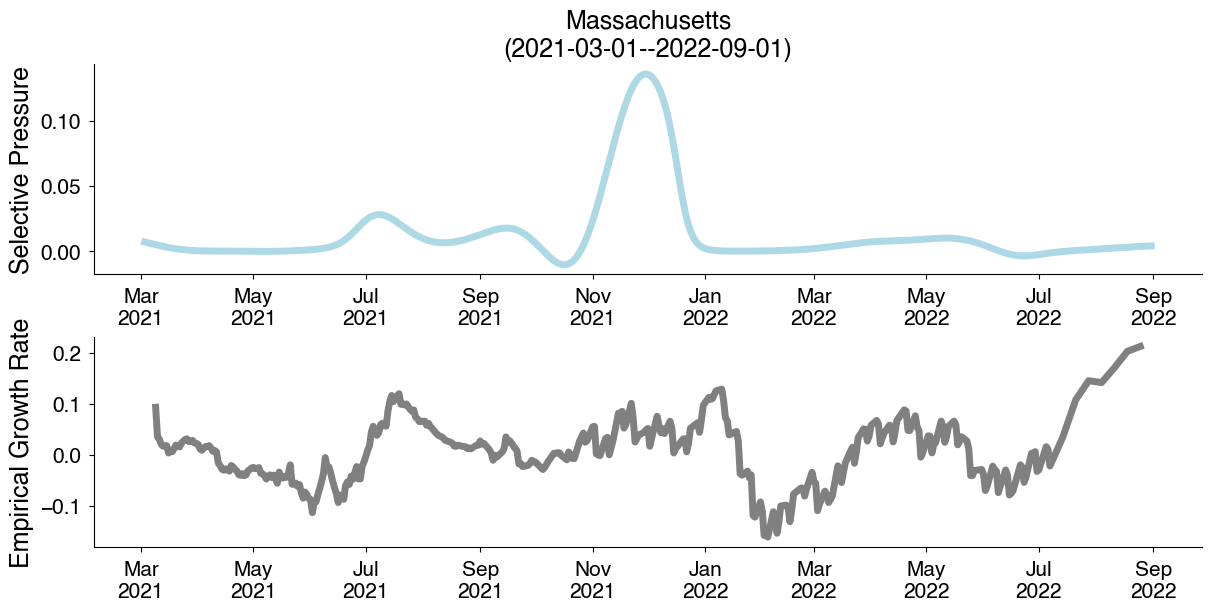

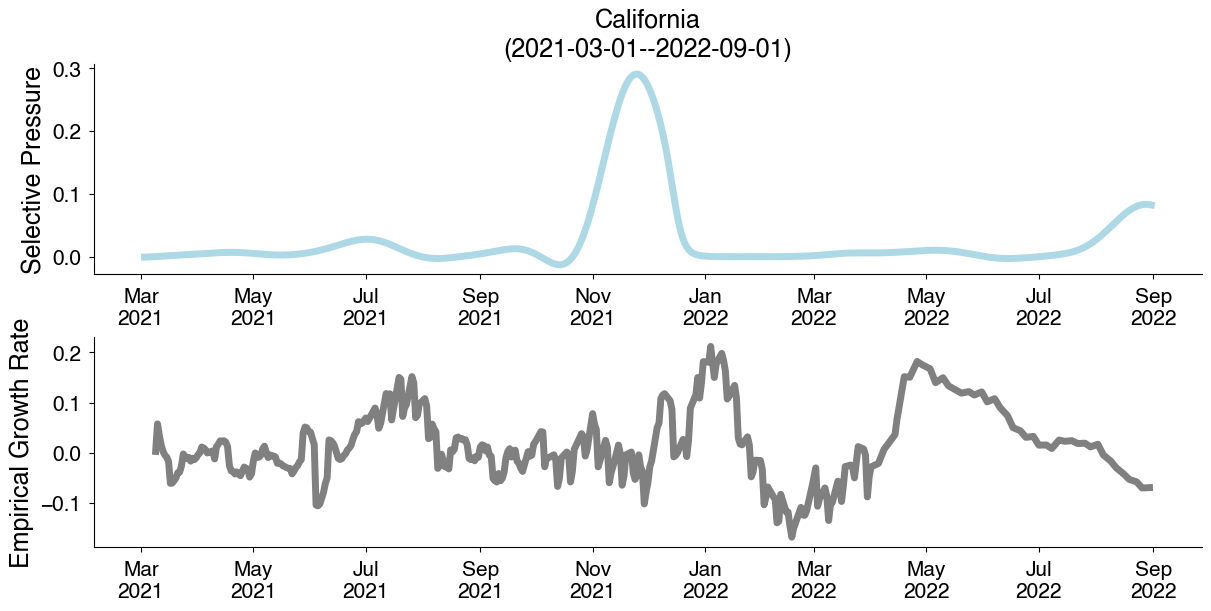

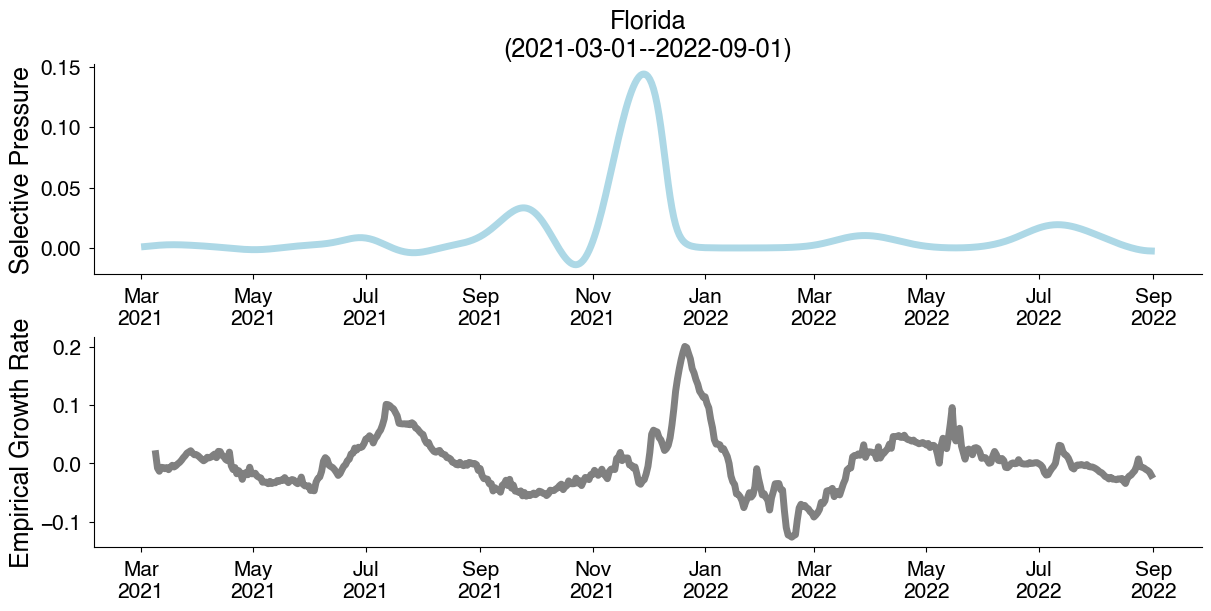

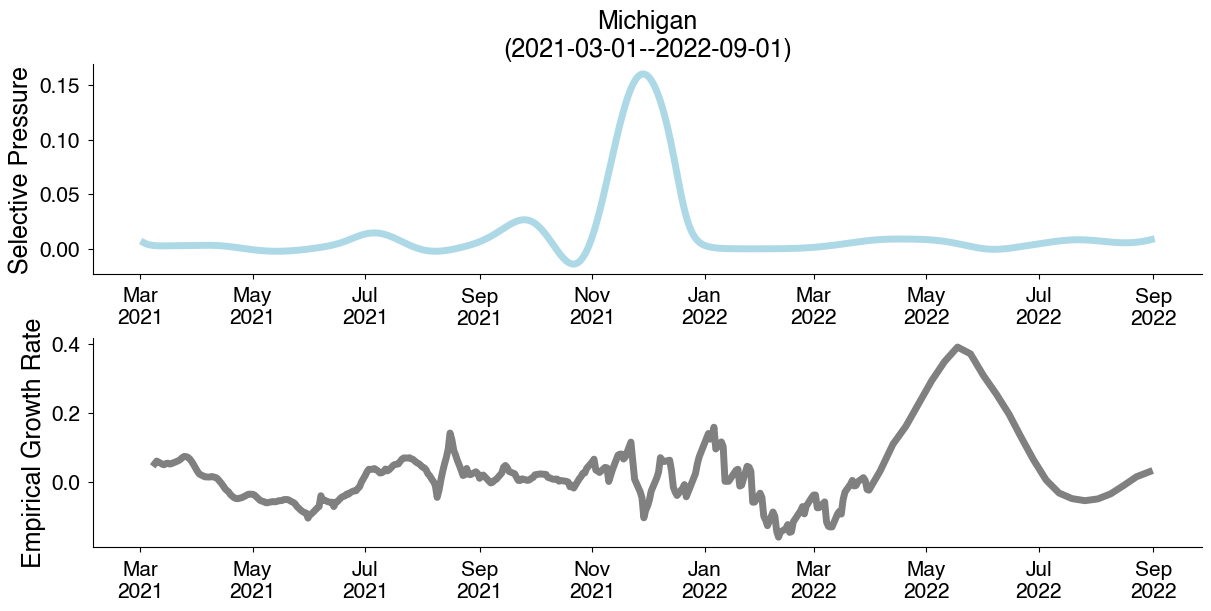

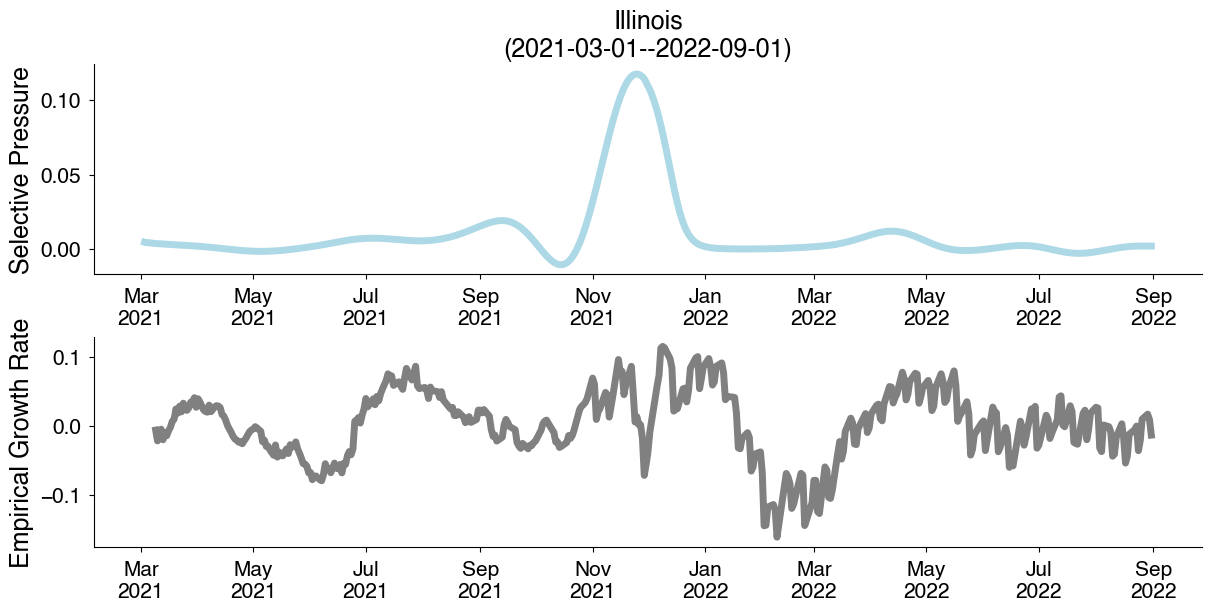

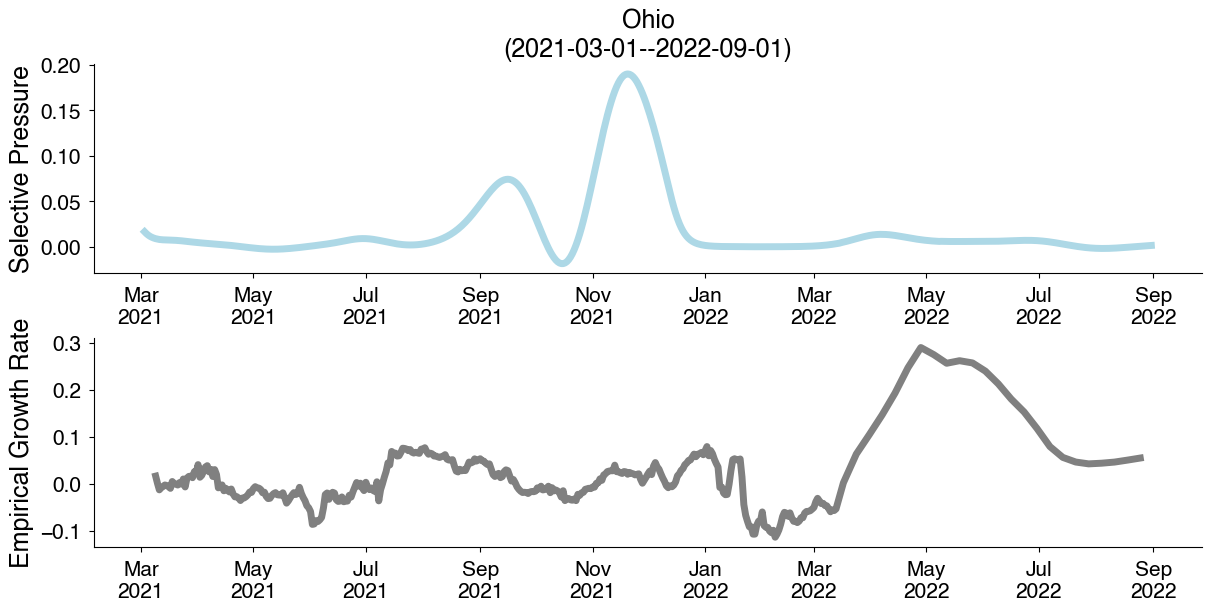

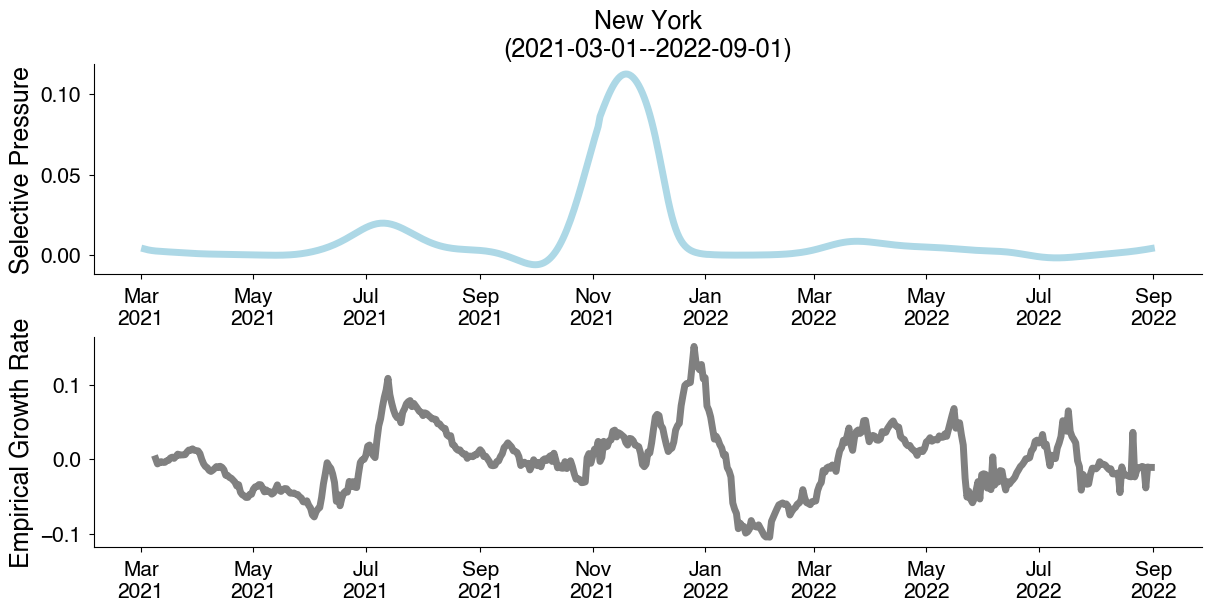

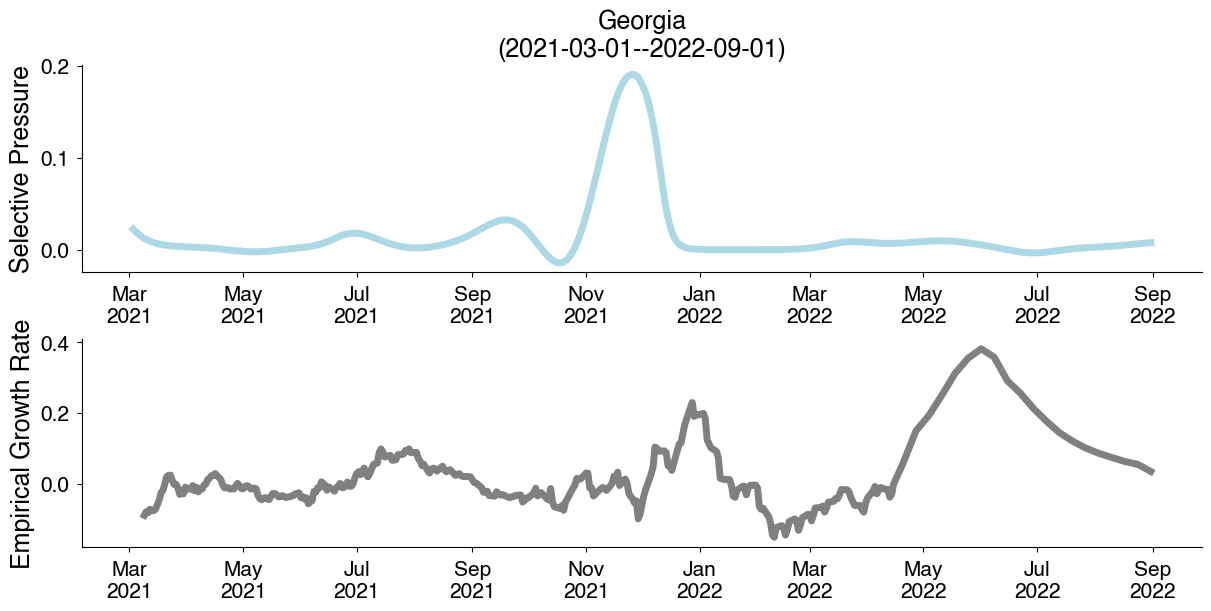

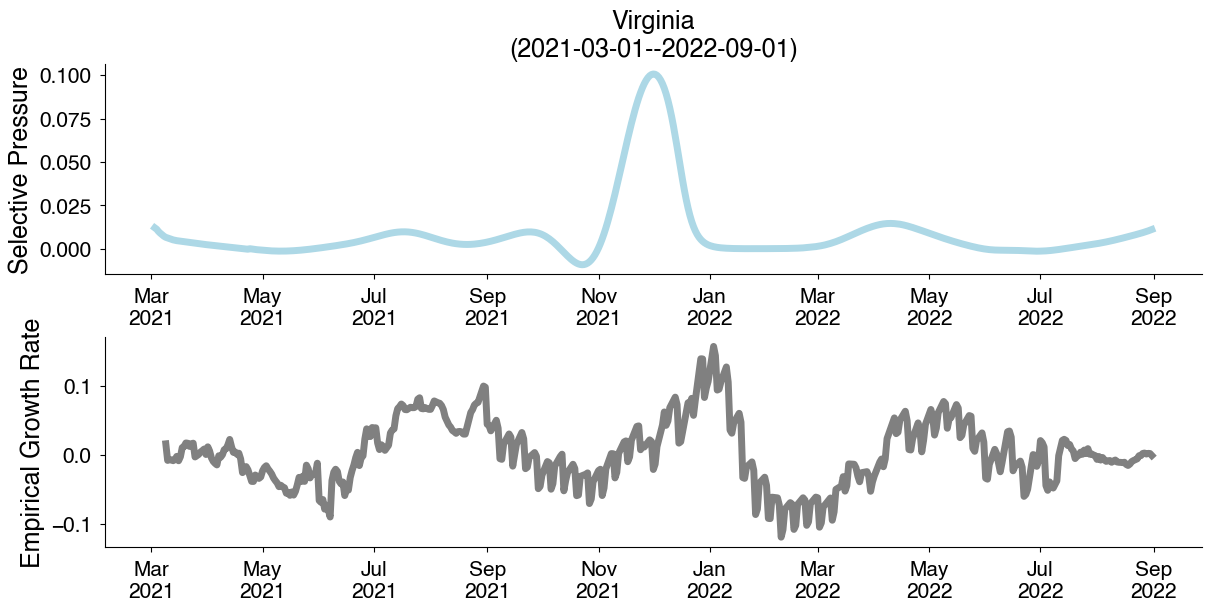

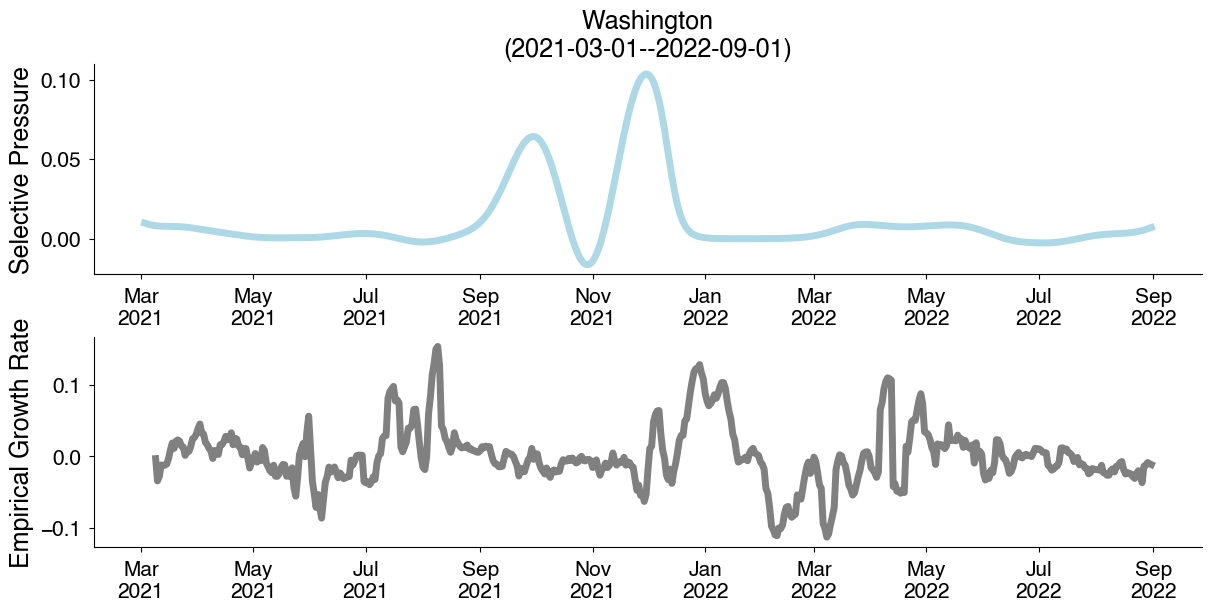

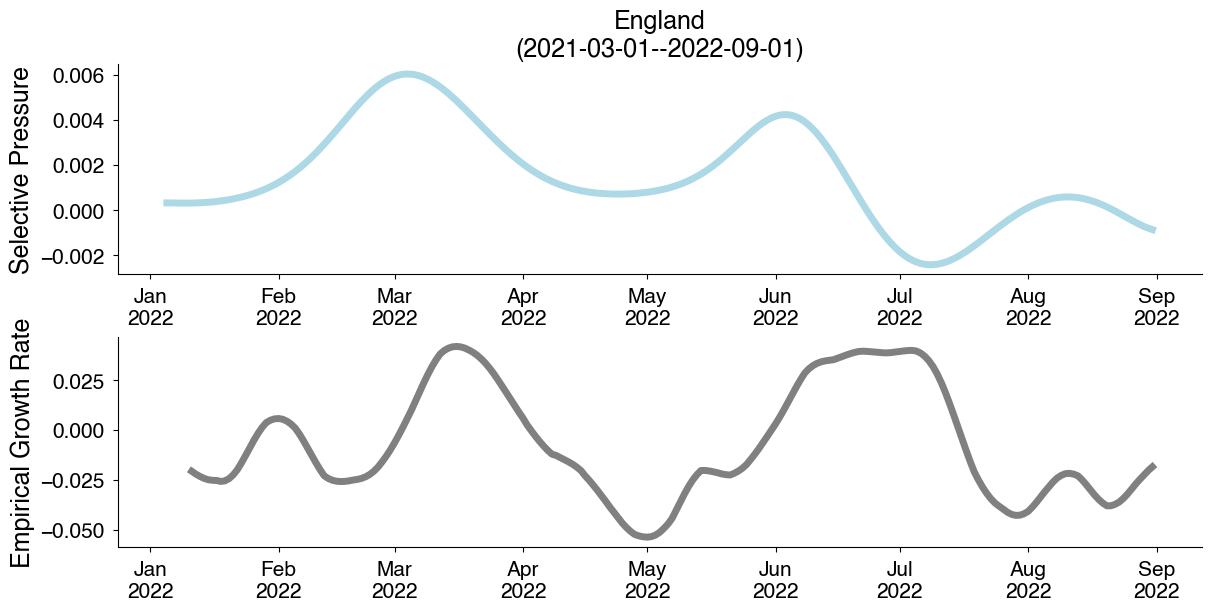

In [69]:
#from sklearn.linear_model import Ridge
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import SplineTransformer

#def fit_spline(cases, data, loc, n_knots, degree):
#    t_cases = np.array([i for i, t in enumerate(data[loc].dates) if t in pd.to_datetime(cases[loc].date.values)])
#    t_pred = np.arange(len(data[loc].dates))
    
#    model = make_pipeline(SplineTransformer(n_knots=n_knots, degree=degree), Ridge(alpha=1e-3))
#    model.fit(t_cases.reshape(-1, 1), np.log(cases[loc].cases))
#    return model, np.exp(model.predict(t_cases.reshape(-1, 1)))


def plot_selective_pressure_growth(loc, window_n):
    # Compute selective pressure
    delta_bar, selective_pressure = compute_selective_pressure(posteriors[loc])
    
    # Prep data
    t_cases = [t for i, t in enumerate(data[loc].dates) if t in pd.to_datetime(cases[loc].date.values)]
    #_, smooth_cases = fit_spline(cases, data, loc, n_knots=42, degree=4)
    #empirical_growth = np.diff(np.log(smooth_cases))

    smooth_cases = cases[loc].cases.rolling(window=7, min_periods=7).mean()
    empirical_growth = np.log(smooth_cases / smooth_cases.shift(1)).rolling(window=7, min_periods=1).mean()
    

    fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=2)

    # Plot selective pressure
    ax0 = fig.add_subplot(spec[0, 0])
    t = np.arange(len(selective_pressure))
    ax0.plot(data[loc].dates, selective_pressure, color="lightblue")
    ax0.set_ylabel("Selective Pressure")
    ax0.set_title(loc + f"\n({date_start}--{date_end})")
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

    # Plot empirical growth rates
    ax1 = fig.add_subplot(spec[1, 0], sharex = ax0)
    #ax1.plot(t_cases, cases[loc].cases.values, color="gray")
    #ax1.plot(t_cases, smooth_cases, color="red")
    ax1.plot(t_cases, empirical_growth, color="gray")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax1.set_ylabel("Empirical Growth Rate")
    return fig

window_n = 14
fig_selective_pressure_growth = {}
for loc in locations:
    fig_selective_pressure_growth[loc] = plot_selective_pressure_growth(loc, window_n)
    fig_selective_pressure_growth[loc].savefig(f"figures/selective_pressure_growth_{loc}.png")
fig_selective_pressure_growth

In [98]:
def make_dataframes(loc):
    # Create selective pressure column for each date
    delta_bar, selective_pressure = compute_selective_pressure(posteriors[loc])
    selective_pressure_df = pd.DataFrame({"selective_pressure": selective_pressure[:,-1], "date": data[loc].dates})
    
    # Create smooth cases and empirical growth dataframe
    t_cases = [t for i,t in enumerate(data[loc].dates) if t in pd.to_datetime(cases[loc].date.values)]
    #smooth_cases = cases[loc].cases.rolling(window=7, min_periods=1).mean().values
    #empirical_growth = np.diff(np.log(smooth_cases), prepend=np.nan)
    #empirical_growth_change = np.diff(empirical_growth, prepend=np.nan)
    smooth_cases = cases[loc].cases.rolling(window=7, min_periods=1).mean()
    empirical_growth = np.log(smooth_cases / smooth_cases.shift(1)).rolling(window=7, min_periods=1).mean()
    empirical_growth_change = empirical_growth.diff()
    
    growth_df = pd.DataFrame({"date": t_cases, 
                              "cases": cases[loc].cases,
                              "smooth_cases": smooth_cases, 
                              "empirical_growth_rate": empirical_growth,
                              "empirical_growth_change": empirical_growth_change
                             })
    # Merge on date
    selective_pressure_df = selective_pressure_df.merge(growth_df, on="date", how="left")
    selective_pressure_df["location"] = loc
    return selective_pressure_df

selective_pressure_dfs = {}
for loc in locations:
    selective_pressure_dfs[loc] = make_dataframes(loc)

selective_pressure_dfs["Washington"]

selective_pressure       date   cases  smooth_cases  \
0                   NaN 2021-03-02   371.0    371.000000   
1              0.009964 2021-03-03  1013.0    692.000000   
2              0.009591 2021-03-04   746.0    710.000000   
3              0.009226 2021-03-05   841.0    742.750000   
4              0.008919 2021-03-06   765.0    747.200000   
..                  ...        ...     ...           ...   
543            0.005556 2022-08-27  2550.0   1274.714286   
544            0.005902 2022-08-28   857.0   1252.000000   
545            0.006279 2022-08-29   817.0   1257.857143   
546            0.006685 2022-08-30  1017.0   1238.285714   
547            0.007120 2022-08-31  1088.0   1200.000000   

     empirical_growth_rate  empirical_growth_change    location  
0                      NaN                      NaN  Washington  
1                 0.623384                      NaN  Washington  
2                 0.324531                -0.298852  Washington  
3                 0.231386                -0.093146  Washington  
4                 0.175033                -0.056353  Washington  
..                     ...                      ...         ...  
543              -0.013742                 0.023118  Washington  
544              -0.012434                 0.001308  Washington  
545              -0.008641                 0.003794  Washington  
546              -0.010207                -0.001567  Washington  
547              -0.011450                -0.001243  Washington  

[548 rows x 7 columns]

In [125]:
def save_input_dfs(selective_pressure_dfs):
    df = pd.concat([df_loc for df_loc in selective_pressure_dfs.values()])
    df.to_csv("../data/selective_pressure_growth_cases.tsv", sep="\t", index=False)
    return None
save_input_dfs(selective_pressure_dfs) # Can now load this file instead of running models again

In [100]:
def create_lagged_features(df, columns, max_lag, dropna=True):
    """
    Generate lagged predictors for specified columns in a pandas DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing the original data.
    - columns: list of column names for which to generate lagged predictors.
    - max_lag: maximum number of lags to generate.
    - dropna: boolean indicating whether to drop rows with NaN values resulting from lagging.
    
    Returns:
    - A pandas DataFrame with original and lagged predictors.
    """
    result_df = df.copy()
    for col in columns:
        for lag in range(1, max_lag + 1):
            result_df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    if dropna:
        result_df = result_df.dropna().reset_index(drop=True)
    
    return result_df

input_dfs = {}
TARGET = "empirical_growth_rate"
keep_features = ["date", "location", "selective_pressure"]
keep_targets = [TARGET]
for loc in locations:
    input_dfs[loc] = create_lagged_features(
        selective_pressure_dfs[loc][keep_features + keep_targets], 
        ["selective_pressure"], 
        14)

input_dfs["California"]

date    location  selective_pressure  empirical_growth_rate  \
0   2021-03-17  California            0.001957              -0.060372   
1   2021-03-18  California            0.002147              -0.059884   
2   2021-03-19  California            0.002328              -0.055193   
3   2021-03-20  California            0.002499              -0.049582   
4   2021-03-21  California            0.002662              -0.039297   
..         ...         ...                 ...                    ...   
353 2022-08-16  California            0.066905              -0.041635   
354 2022-08-19  California            0.073691              -0.052504   
355 2022-08-23  California            0.080266              -0.057318   
356 2022-08-26  California            0.082892              -0.069552   
357 2022-08-30  California            0.083004              -0.068877   

     selective_pressure_lag_1  selective_pressure_lag_2  \
0                    0.001758                  0.001546   
1                    0.001957                  0.001758   
2                    0.002147                  0.001957   
3                    0.002328                  0.002147   
4                    0.002499                  0.002328   
..                        ...                       ...   
353                  0.064379                  0.061754   
354                  0.071579                  0.069311   
355                  0.078931                  0.077382   
356                  0.082255                  0.081377   
357                  0.083342                  0.083437   

     selective_pressure_lag_3  selective_pressure_lag_4  \
0                    0.001333                  0.001116   
1                    0.001546                  0.001333   
2                    0.001758                  0.001546   
3                    0.001957                  0.001758   
4                    0.002147                  0.001957   
..                        ...                       ...   
353                  0.059049                  0.056282   
354                  0.066905                  0.064379   
355                  0.075631                  0.073691   
356                  0.080266                  0.078931   
357                  0.083288                  0.082892   

     selective_pressure_lag_5  selective_pressure_lag_6  \
0                    0.000897                  0.000677   
1                    0.001116                  0.000897   
2                    0.001333                  0.001116   
3                    0.001546                  0.001333   
4                    0.001758                  0.001546   
..                        ...                       ...   
353                  0.053475                  0.050645   
354                  0.061754                  0.059049   
355                  0.071579                  0.069311   
356                  0.077382                  0.075631   
357                  0.082255                  0.081377   

     selective_pressure_lag_7  selective_pressure_lag_8  \
0                    0.000465                  0.000262   
1                    0.000677                  0.000465   
2                    0.000897                  0.000677   
3                    0.001116                  0.000897   
4                    0.001333                  0.001116   
..                        ...                       ...   
353                  0.047813                  0.044996   
354                  0.056282                  0.053475   
355                  0.066905                  0.064379   
356                  0.073691                  0.071579   
357                  0.080266                  0.078931   

     selective_pressure_lag_9  selective_pressure_lag_10  \
0                    0.000071                  -0.000111   
1                    0.000262                   0.000071   
2                    0.000465                   0.000262   
3                    0.000677                   0.000465 

In [101]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # For regression
from sklearn.metrics import mean_squared_error

WITHHELD_LOCATIONS = ["England"]

def process_inputs(loc, target):
    X = input_dfs[loc].drop(target, axis=1)  # Features
    y = input_dfs[loc][target]  # Target
    if "date" in X.columns:
        X.drop("date", axis=1)
    return X, y

def process_inputs_all(locations, target):
    Xs, ys = [], []
    input_df = pd.concat([df for _, df in input_dfs.items()])
    X = input_df.sort_values(["date"]).reset_index(drop=True)
    dates = X["date"]
    locations = X["location"]
    
    y = X[target]  # Target
    #X = X.drop([target], axis=1) #"date", "location"], axis=1)  # Features
    X = X.drop([target, "date", "location"], axis=1)  # Features

    return dates, locations, X, y
    
dates_vec, locations_vec, X, y = process_inputs_all(locations, target=TARGET)

# Withold certain locations for testing
X, y, X_withhold, y_withhold = X[~locations_vec.isin(WITHHELD_LOCATIONS)], y[~locations_vec.isin(WITHHELD_LOCATIONS)], X[locations_vec.isin(WITHHELD_LOCATIONS)], y[locations_vec.isin(WITHHELD_LOCATIONS)],

# Split to hold final section for testing best model after CV
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

X_test = pd.concat((X_withhold, X_test))
y_test = pd.concat((y_withhold, y_test))

In [110]:
# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1e-3),
    'Lasso': Lasso(alpha=1e-6),
    'GradientBoostingA': GradientBoostingRegressor(loss="absolute_error", n_estimators=150, max_depth=3),
    'GradientBoostingB': GradientBoostingRegressor(loss="absolute_error", n_estimators=150, max_depth=5),
    'GradientBoostingC': GradientBoostingRegressor(loss="absolute_error", n_estimators=150, max_depth=7),

}
model_scores = {model: [] for model in models}

# Define the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Perform time series cross-validation for model selection
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Initialize and train your linear model within each split
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        mse = mean_squared_error(y_val, predictions)
        
        # Append the MSE to the model's list of scores
        model_scores[model_name].append(mse)

for model_name, scores in model_scores.items():
    print(f"{model_name}: Mean MSE = {np.mean(scores):.4f}, Std MSE = {np.std(scores):.4f}")
    
best_model_name = min(model_scores, key=lambda k: np.mean(model_scores[k]))

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.835e-03, tolerance: 5.968e-04
  model = cd_fast.enet_coordinate_descent(
/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.055e-02, tolerance: 7.253e-04
  model = cd_fast.enet_coordinate_descent(


LinearRegression: Mean MSE = 0.0045, Std MSE = 0.0020
Ridge: Mean MSE = 0.0044, Std MSE = 0.0021
Lasso: Mean MSE = 0.0044, Std MSE = 0.0022
GradientBoostingA: Mean MSE = 0.0034, Std MSE = 0.0015
GradientBoostingB: Mean MSE = 0.0033, Std MSE = 0.0015
GradientBoostingC: Mean MSE = 0.0033, Std MSE = 0.0015


In [111]:
# Retrain best model
best_model = models[best_model_name]
best_model.fit(X, y)
predictions = best_model.predict(X_test)

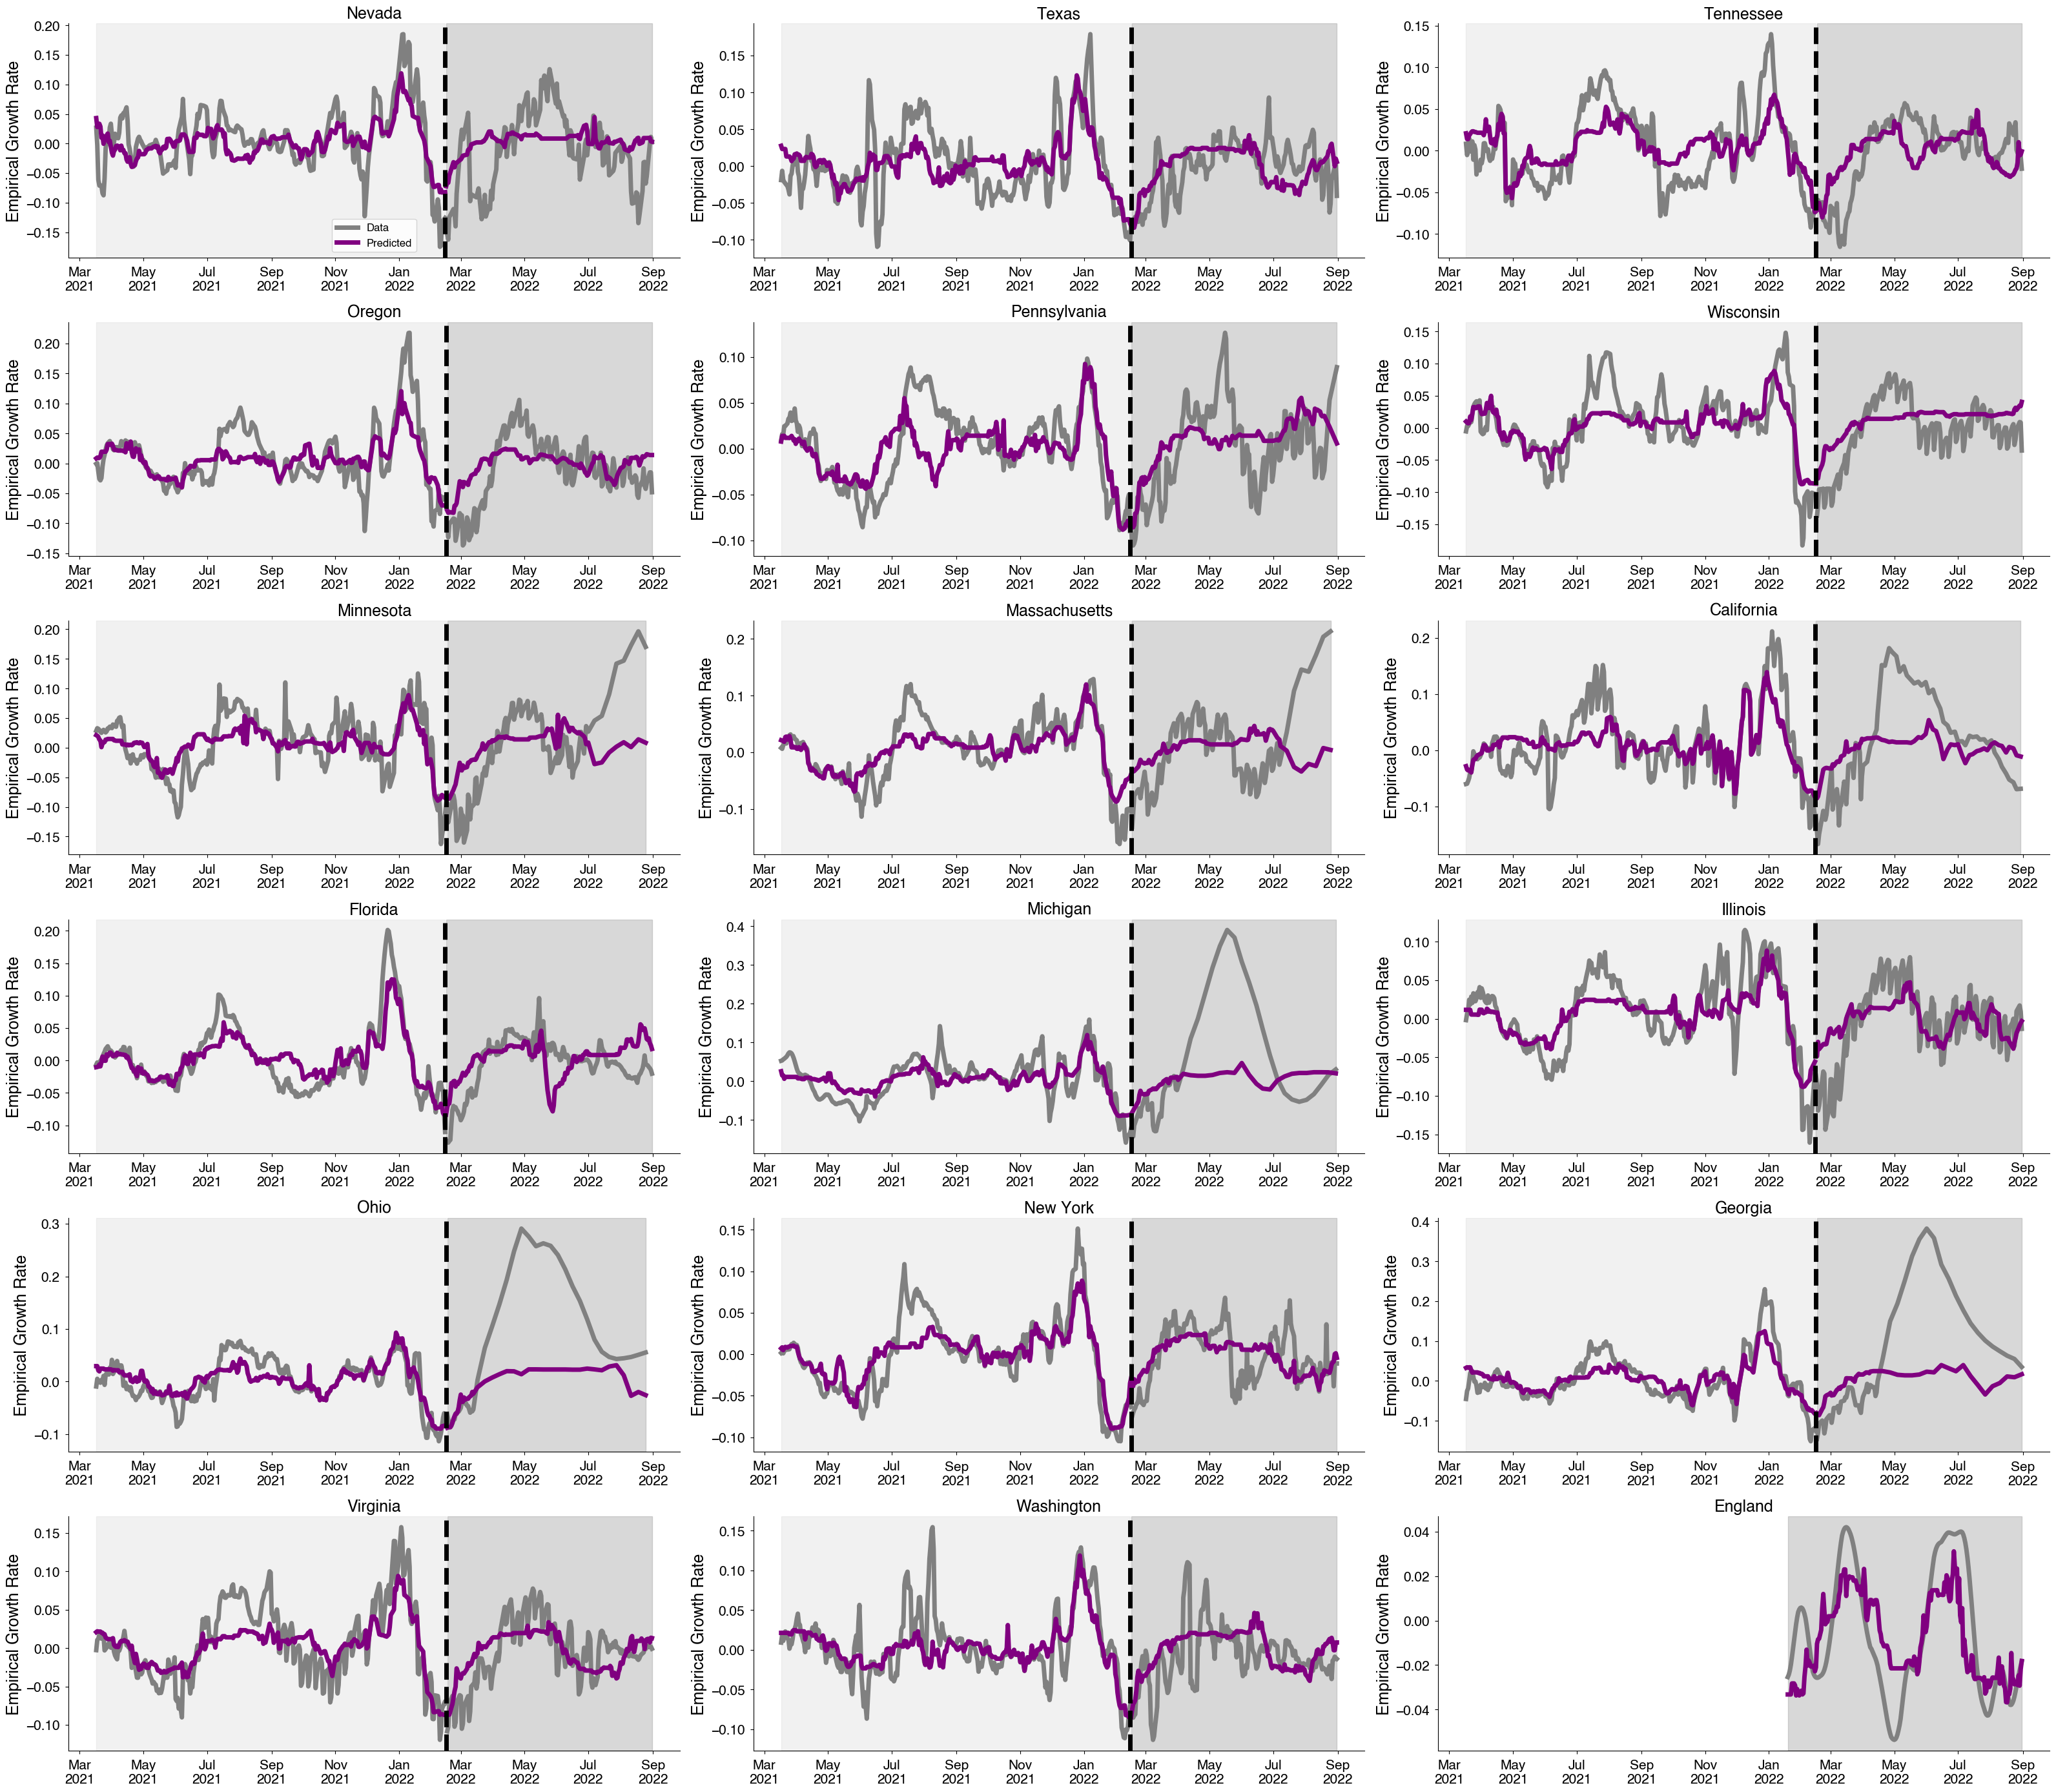

In [124]:
def plot_yeqx(ax):
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
        return None
    
fig = plt.figure(figsize=(32, 32))
spec = fig.add_gridspec(ncols=3, nrows=len(locations) // 3 + 1)

for l, loc in enumerate(locations):
    ax = fig.add_subplot(spec[l], sharex=None if l==0 else ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X.index]
    loc_idx_test = loc_idx[X_test.index]

    # Plot data points
    ax.plot(dates_vec[X.index][loc_idx_train], y[loc_idx_train], color="grey", label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color="grey")
    
    # Make predictions
    predictions = model.predict(X)
    predictions_test = model.predict(X_test)

    ax.plot(dates_vec[X.index][loc_idx_train], predictions[loc_idx_train], color="purple", label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], predictions_test[loc_idx_test], color="purple")
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X.index][loc_idx_train].min(), dates_vec[X.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color="lightgrey", alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color="grey", alpha=0.3)

    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    if l == 0:
        ax.legend()
fig.tight_layout()
fig.savefig("../manuscript/supplementary_figures/empirical-growth-rate-predictions-all.png")
#TODO: 
# 1. Validation on England predicting BQ.1 and BA.5
# 2. Split out on US + Global

# TODO:
# 1. Figure on cross-validation scheme

# TODO:
# Update to Latent Immunity model

In [113]:
# Figure 1:

# A. Overview of the method here. Cross-validation time series and general organization of this analysis
# B. Selection of states to highlight train-test split
# C. Out-sample forecasts on England, potentially Scotland, Wales .etc (may be a lot of work)

In [115]:
# Subset locations
locations_subset = ["California",   "Michigan", "Nevada", "New York", "Texas", "Washington"]
target_locations = ["England"]

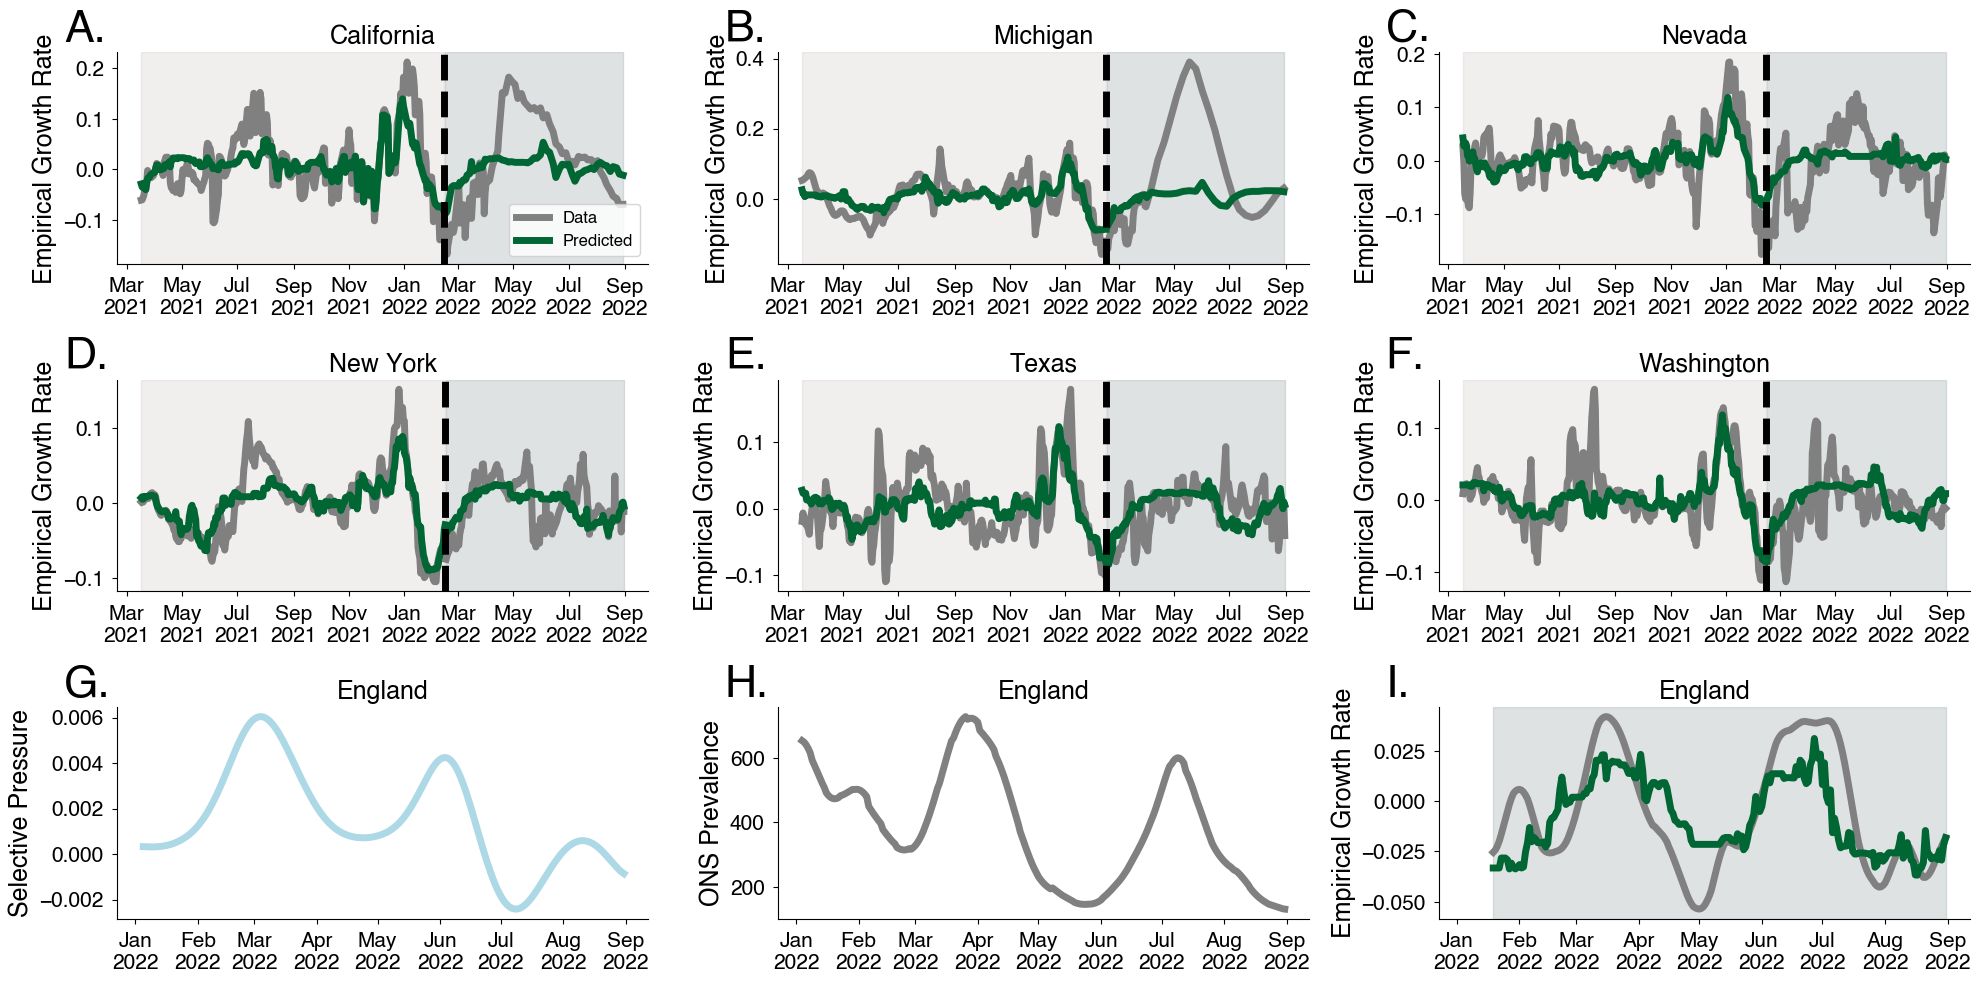

In [118]:
fig = plt.figure(figsize=(20, 10))
spec = fig.add_gridspec(ncols=3, nrows=len(locations_subset) // 3 + 1)

TRAIN_PERIOD_COLOR, TEST_PERIOD_COLOR = "#d1c7c9", "#949fa5"
PREDICTION_COLOR = "#006633"
DATA_COLOR = "grey"

axes = []

for l, loc in enumerate(locations_subset):
    ax = fig.add_subplot(spec[l], sharex=None if l==0 else ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X.index]
    loc_idx_test = loc_idx[X_test.index]

    # Plot data points
    ax.plot(dates_vec[X.index][loc_idx_train], y[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    predictions = model.predict(X)
    predictions_test = model.predict(X_test)

    ax.plot(dates_vec[X.index][loc_idx_train], predictions[loc_idx_train], color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], predictions_test[loc_idx_test], color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X.index][loc_idx_train].min(), dates_vec[X.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    if l == 0:
        ax.legend()
    axes.append(ax)
    
# Add in target_locations
last_l = l
for l, loc in enumerate(target_locations):
    
    # Add selective pressure
    _l = 0
    ax = fig.add_subplot(spec[-1, 0], sharex=None if _l==0 else ax)
    _, selective_pressure = compute_selective_pressure(posteriors[loc])
    ax.plot(data[loc].dates, selective_pressure, color="lightblue")
    ax.set_ylabel("Selective Pressure")
    ax.set_title(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)
    
    # Add prevalence
    ax = fig.add_subplot(spec[-1, 1], sharex = ax)
    t_cases = [t for i, t in enumerate(data[loc].dates) if t in pd.to_datetime(cases[loc].date.values)]
    ax.plot(t_cases, cases[loc].cases, color="gray")
    ax.set_title(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax.set_ylabel("ONS Prevalence")
    axes.append(ax)
   
    # Add predictions
    ax = fig.add_subplot(spec[-1, -1], sharex=ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X.index]
    loc_idx_test = loc_idx[X_test.index]
    
    # Plot data points
    ax.plot(dates_vec[X.index][loc_idx_train], y[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    predictions = model.predict(X)
    predictions_test = model.predict(X_test)

    ax.plot(dates_vec[X.index][loc_idx_train], predictions[loc_idx_train], color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], predictions_test[loc_idx_test], color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X.index][loc_idx_train].min(), dates_vec[X.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)

ax_labels = string.ascii_uppercase 
for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=32, weight='bold')
fig.tight_layout()


# TODO: Could add part that has variant frequencies
fig.savefig("../manuscript/figures/selective_pressure_prediction.png")